In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Colgate88_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Colgate88_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Colgate88', ref_nodes) 
            np.save('results/info_ref_nodes_Colgate88', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 2 Feature value  2007  gap  [0.90496458]  volume:  68381.0  size: 588 conductance:  0.41600737046840497
Reached
Number of feature 2 Feature value  2008  gap  [0.89580114]  volume:  62429.0  size: 640 conductance:  0.29311698089029137
Reached
Number of feature 2 Feature value  2009  gap  [0.87791738]  volume:  35369.0  size: 638 conductance:  0.11973762334247505


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_Colgate88.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Colgate88.npy') 

## Visualize the ground truth clusters

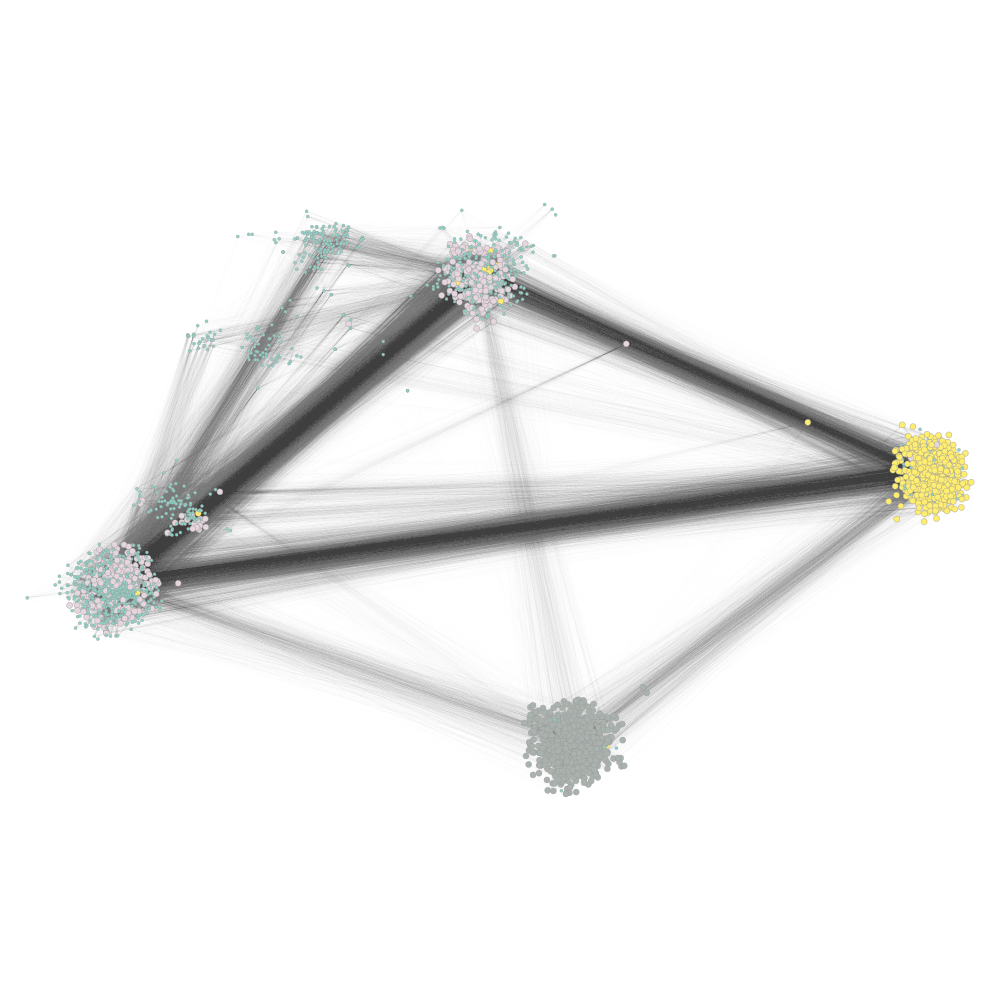

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14b4ba7f0, at 0x14b4b3ef0>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Colgate88', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Colgate88', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Colgate88', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Colgate88', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Colgate88', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Colgate88', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Colgate88', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Colgate88', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Colgate88', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Colgate88', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Colgate88', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Colgate88', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Colgate88', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Colgate88', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Colgate88', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Colgate88', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Colgate88', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Colgate88', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Colgate88', cuts_acl_ALL) 
    
    np.save('results/nodes_Colgate88', nodes)

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.25231872653861537 f1score:  0.5293545713782325 precision:  0.4779416963212594 recall:  0.593161843202059
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.271126501141973 f1score:  0.467703820401733 precision:  0.3369858949635926 recall:  0.7641011392053348
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.2368296155671571 f1score:  0.5030695003011699 precision:  0.43074454562503905 recall:  0.6045831444407073
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.17376650979201458 f1score:  0.6143584768372544 precision:  0.5076394522116715 recall:  0.7778915195741507
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.19855871942858966 f1score:  0.5622196204806009 precision:  0.4656706959953146 recall:  0.709275968470774
outer: 0 n

outer: 0 number of node:  3180  completed:  0.13945578231292516  degree:  51.0
conductance:  0.26654037244879725 f1score:  0.5682470778482142 precision:  0.4902499575623833 recall:  0.675757885962475
outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.18264470249347375 f1score:  0.7457139373247164 precision:  0.6394462510063886 recall:  0.8943419955835685
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.29727812177502577 f1score:  0.5817962491365177 precision:  0.44927190070142753 recall:  0.8252146063965137
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.14130967128575955 f1score:  0.6066194900730966 precision:  0.5043373750884437 recall:  0.7609423670317779
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.39232650111934764 f1score:  0.25084927828130243 precision:  0.18074224091225716 recall:  0.409806817

outer: 0 number of node:  3465  completed:  0.2789115646258503  degree:  194.0
conductance:  0.18360004962163504 f1score:  0.6026219154815019 precision:  0.5098001517834556 recall:  0.7367689855369182
outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.1616020039960636 f1score:  0.4903966232638501 precision:  0.3533509643294846 recall:  0.8010997206826458
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.14568113450795014 f1score:  0.6381273539458702 precision:  0.5099614142845893 recall:  0.852342024831459
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.19439469632701795 f1score:  0.5787717824651895 precision:  0.4859401849479027 recall:  0.7154472733654085
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.16874772699721177 f1score:  0.7045602399580879 precision:  0.5810133313076835 recall:  0.8948392097219988


outer: 0 number of node:  904  completed:  0.41836734693877553  degree:  77.0
conductance:  0.19400730202694197 f1score:  0.495440712510819 precision:  0.4007352941176471 recall:  0.6487620830347611
outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.3455598704666555 f1score:  0.4461224453257182 precision:  0.3214476917817497 recall:  0.728784311431538
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.15143509066890837 f1score:  0.6475283669884357 precision:  0.531875693256378 recall:  0.8274520700194499
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.256335156895128 f1score:  0.43824280148672246 precision:  0.3158349953849828 recall:  0.7155788888726401
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.2585117845552322 f1score:  0.4412154300545959 precision:  0.3178831434301227 recall:  0.7209166288881415
outer

outer: 0 number of node:  2745  completed:  0.5612244897959183  degree:  20.0
conductance:  0.12545009361947285 f1score:  0.4018120541249086 precision:  0.2518677340139032 recall:  0.9929366344452406
outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.2413385161399358 f1score:  0.6496943209377527 precision:  0.5717858929464732 recall:  0.7521826238282564
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.16257127145379294 f1score:  0.6260112009956441 precision:  0.5297578660617538 recall:  0.7650078238107076
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.21125815697993536 f1score:  0.5423801527278966 precision:  0.4668354697473229 recall:  0.6470949532764949
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.24542956301848817 f1score:  0.4562544220245932 precision:  0.3288130998560668 recall:  0.7450022667115135

outer: 0 number of node:  1536  completed:  0.7040816326530612  degree:  106.0
conductance:  0.1678599379692165 f1score:  0.5801821388559195 precision:  0.46732963429561925 recall:  0.764890832248724
outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.19000278732695344 f1score:  0.3949702176337029 precision:  0.2460969700896698 recall:  0.9997660168760328
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.22997348348446656 f1score:  0.5917437849543988 precision:  0.4785026313176447 recall:  0.775200713648528
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.27595940804475194 f1score:  0.51343552031692 precision:  0.420305656509179 recall:  0.6595838025182433
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.18802660753880265 f1score:  0.6391499129056877 precision:  0.5311797970408242 recall:  0.8022111405214899
outer: 

outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.13457748927784863 f1score:  0.6294318088028957 precision:  0.5272754210084448 recall:  0.780684693116509
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.1493531714021093 f1score:  0.4257985323549032 precision:  0.33524379380472963 recall:  0.5833784238311812
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.16101769521964962 f1score:  0.6954615977172368 precision:  0.5527911208465207 recall:  0.9373948903935304
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.19950216959870834 f1score:  0.43835628696967255 precision:  0.315802028198797 recall:  0.7163539579707814
outer: 0 number of node:  1911  completed:  0.8605442176870748  degree:  282.0
conductance:  0.23198031980319803 f1score:  0.5231881283988425 precision:  0.4253247050424245 recall:  0.67954548778169

outer: 0 number of node:  85  completed:  0.9863945578231292  degree:  88.0
conductance:  0.20364447029175148 f1score:  0.4797661467939191 precision:  0.34570696807240964 recall:  0.7836533540018427
outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.24467700186478888 f1score:  0.558091336305579 precision:  0.47455404256191147 recall:  0.6773226481040056
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.25519590262278585 f1score:  0.474584807544604 precision:  0.41666574545936924 recall:  0.5512057442856934
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.16572981654209648 f1score:  0.5774023253825767 precision:  0.45491744617793906 recall:  0.790146385691932
320
outer: 1 number of node:  1116  completed:  0.0  degree:  186.0
conductance:  0.25142794446990185 f1score:  0.5742505934526986 precision:  0.40281264723156257 recall:  0.9997437088532573
outer: 1 nu

outer: 1 number of node:  1894  completed:  0.125  degree:  79.0
conductance:  0.28043706823708503 f1score:  0.5734267663530775 precision:  0.4021528122641935 recall:  0.998814653446315
outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.25643110680864795 f1score:  0.5421590862042792 precision:  0.380296869958051 recall:  0.9439042752566916
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.15900147195770375 f1score:  0.4712193014308762 precision:  0.3304260942435377 recall:  0.8210767431802528
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.24318046917339803 f1score:  0.5732832534169429 precision:  0.4020246308595009 recall:  0.9987345624629579
outer: 1 number of node:  1646  completed:  0.1375  degree:  74.0
conductance:  0.2730019172298933 f1score:  0.5735832061910627 precision:  0.40217174158208474 recall:  0.9996475996732288
outer: 1 number of node:  3398  completed:  0.140625  de

outer: 1 number of node:  1346  completed:  0.2625  degree:  97.0
conductance:  0.2564004979777716 f1score:  0.5741759252446472 precision:  0.40269759461255134 recall:  1.0
outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.299786406138081 f1score:  0.5731600776156187 precision:  0.40196577944315814 recall:  0.9983501257428439
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.28744338490522214 f1score:  0.5744839660892002 precision:  0.4032248675708714 recall:  0.998622435086258
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.2889688945667112 f1score:  0.5741474946876524 precision:  0.40270599849021543 recall:  0.9997757452466002
outer: 1 number of node:  947  completed:  0.275  degree:  133.0
conductance:  0.2736270259110148 f1score:  0.5739990713625686 precision:  0.40252363083033516 recall:  1.0
outer: 1 number of node:  2044  completed:  0.278125  degree:  130.0
conductance:  0.295

outer: 1 number of node:  436  completed:  0.4  degree:  105.0
conductance:  0.2797367911747629 f1score:  0.9175415906881844 precision:  0.9202842502175385 recall:  0.9148152301013952
outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.2444225572971677 f1score:  0.5687501153370611 precision:  0.39941163892254755 recall:  0.9873616428262506
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.2604850951135226 f1score:  0.5746625913719137 precision:  0.40319736459645383 recall:  0.9998718544266286
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.2693054614664989 f1score:  0.5734785488262566 precision:  0.40223233007516374 recall:  0.9986384532829294
outer: 1 number of node:  343  completed:  0.4125  degree:  146.0
conductance:  0.21890383560760024 f1score:  0.5722416329532917 precision:  0.4012934341773539 recall:  0.9969245062390876
outer: 1 number of node:  2822  completed:  0.415625  degr

outer: 1 number of node:  1719  completed:  0.5375  degree:  73.0
conductance:  0.2819073790954657 f1score:  0.5734704389095324 precision:  0.402208761506654 recall:  0.9987345624629579
outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.2785698479436032 f1score:  0.9319225108397311 precision:  0.925757911042266 recall:  0.9381697608483237
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.2633626260015508 f1score:  0.5742279765549821 precision:  0.4029335745670716 recall:  0.9988627080363293
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.2950806972240155 f1score:  0.5745386841668664 precision:  0.4033022987985171 recall:  0.9984782713162152
outer: 1 number of node:  2434  completed:  0.55  degree:  59.0
conductance:  0.2621393044454336 f1score:  0.5746678819012898 precision:  0.40320257342729615 recall:  0.9998718544266286
outer: 1 number of node:  2744  completed:  0.553125  degree:  1

outer: 1 number of node:  3125  completed:  0.675  degree:  70.0
conductance:  0.24007278452425507 f1score:  0.572428670649979 precision:  0.40150860122081844 recall:  0.9967322878790306
outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.2819053518654742 f1score:  0.575361784496267 precision:  0.40388609585185475 recall:  0.9998718544266286
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.26775335909228715 f1score:  0.575389724195185 precision:  0.4040261414201605 recall:  0.9991830719697576
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.2304267305073918 f1score:  0.5707136220204418 precision:  0.40031232052862187 recall:  0.9937048487081325
outer: 1 number of node:  128  completed:  0.6875  degree:  77.0
conductance:  0.30094230024525626 f1score:  0.5731084009219345 precision:  0.40201368271589 recall:  0.9977414342693299
outer: 1 number of node:  2385  completed:  0.690625  degree:

outer: 1 number of node:  1805  completed:  0.8125  degree:  149.0
conductance:  0.2557016921150793 f1score:  0.5740867637658031 precision:  0.4026462467421877 recall:  0.9997757452466002
outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.2323035412282627 f1score:  0.5670471642120665 precision:  0.3977781794239533 recall:  0.9870893334828365
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.24826887459101557 f1score:  0.5640013616332239 precision:  0.39561297650315896 recall:  0.9819635105479825
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.2769736120343063 f1score:  0.5742320112610748 precision:  0.40278916086398164 recall:  0.9997757452466002
outer: 1 number of node:  815  completed:  0.825  degree:  62.0
conductance:  0.2660271091527261 f1score:  0.5746172148613137 precision:  0.40313186103577425 recall:  1.0
outer: 1 number of node:  2373  completed:  0.828125  degree:  32.0
c

outer: 1 number of node:  42  completed:  0.95  degree:  60.0
conductance:  0.22418755052546482 f1score:  0.5732029817464779 precision:  0.4023152789005659 recall:  0.9964599785356164
outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.2783160665213072 f1score:  0.574199690039412 precision:  0.40272097433846393 recall:  1.0
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.256962500161693 f1score:  0.5751947770718244 precision:  0.40372152586441074 recall:  0.9998718544266286
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.2330248706134407 f1score:  0.5716704003385604 precision:  0.40098862947045083 recall:  0.9953387047686172
outer: 1 number of node:  1563  completed:  0.9625  degree:  119.0
conductance:  0.2308536459409213 f1score:  0.5709921275783216 precision:  0.4005499896715555 recall:  0.9939291034615323
outer: 1 number of node:  669  completed:  0.965625  degree:  56.0
conductance

outer: 2 number of node:  2951  completed:  0.08150470219435736  degree:  6.0
conductance:  0.10890028746970294 f1score:  0.9879606498143991 precision:  0.9863874640662871 recall:  0.9895388617150612
outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.15671371697430328 f1score:  0.9458076190733413 precision:  0.9053047929269428 recall:  0.9901043286493822
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.11787511342077044 f1score:  0.9763862945719145 precision:  0.9629629629629629 recall:  0.9901891486895303
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.12835708320986988 f1score:  0.9673619157976052 precision:  0.944508795086604 recall:  0.9913483559048885
outer: 2 number of node:  264  completed:  0.09404388714733543  degree:  70.0
conductance:  0.1117069799585349 f1score:  0.984988258973499 precision:  0.974015203870076 recall:  0.9962113715400492
oute

outer: 2 number of node:  1463  completed:  0.21316614420062696  degree:  43.0
conductance:  0.15370189386935734 f1score:  0.9536242967171027 precision:  0.9222641908132808 recall:  0.987192173937629
outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.12334541775566985 f1score:  0.9747716766264517 precision:  0.9718404856251581 recall:  0.977720602787752
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.12158795345653661 f1score:  0.9693715748184828 precision:  0.954031485284052 recall:  0.9852130396675054
outer: 2 number of node:  1124  completed:  0.2225705329153605  degree:  30.0
conductance:  0.11015720816144497 f1score:  0.9855465853283149 precision:  0.9755415212453604 recall:  0.9957589979925924
outer: 2 number of node:  2473  completed:  0.22570532915360503  degree:  164.0
conductance:  0.17076261119763483 f1score:  0.938131382078305 precision:  0.9070031412506929 recall:  0.9714721931635047
ou

outer: 2 number of node:  1491  completed:  0.34169278996865204  degree:  114.0
conductance:  0.11882820311866606 f1score:  0.9733598629304151 precision:  0.951868767397238 recall:  0.9958438180327406
outer: 2 number of node:  2942  completed:  0.3448275862068966  degree:  98.0
conductance:  0.1258687681278389 f1score:  0.9663234219704174 precision:  0.942863291547856 recall:  0.9909808023975798
outer: 2 number of node:  2551  completed:  0.34796238244514105  degree:  5.0
conductance:  0.13560191057020266 f1score:  0.9660619114682573 precision:  0.944059152117009 recall:  0.9891147615143204
outer: 2 number of node:  2818  completed:  0.3510971786833856  degree:  78.0
conductance:  0.11516698102740486 f1score:  0.9800198821075035 precision:  0.9707367136358593 recall:  0.9894823150216291
outer: 2 number of node:  1681  completed:  0.3542319749216301  degree:  97.0
conductance:  0.1226420252610859 f1score:  0.9732719918829138 precision:  0.9571873803925857 recall:  0.9899064152223699
out

outer: 2 number of node:  1852  completed:  0.47335423197492166  degree:  68.0
conductance:  0.11297071129707113 f1score:  0.9777623349548297 precision:  0.9615647467264427 recall:  0.9945149707370862
outer: 2 number of node:  1950  completed:  0.47648902821316613  degree:  35.0
conductance:  0.11024373806582051 f1score:  0.980854031360505 precision:  0.977507581714029 recall:  0.9842234725324437
outer: 2 number of node:  424  completed:  0.47962382445141066  degree:  43.0
conductance:  0.11307243963363864 f1score:  0.9806579924088573 precision:  0.9716625034693311 recall:  0.9898215951822217
outer: 2 number of node:  2012  completed:  0.4827586206896552  degree:  12.0
conductance:  0.10906143440102857 f1score:  0.983063235273448 precision:  0.9774442394767734 recall:  0.9887472080070118
outer: 2 number of node:  1055  completed:  0.48589341692789967  degree:  43.0
conductance:  0.12040446227400121 f1score:  0.9771888020289006 precision:  0.9634280375886135 recall:  0.9913483559048885


outer: 2 number of node:  2106  completed:  0.6050156739811913  degree:  69.0
conductance:  0.12283125207205216 f1score:  0.9798924055054846 precision:  0.9686981986959885 recall:  0.9913483559048885
outer: 2 number of node:  688  completed:  0.6081504702194357  degree:  61.0
conductance:  0.15809262505398472 f1score:  0.9375635604560296 precision:  0.8899982216802581 recall:  0.990500155503407
outer: 2 number of node:  3399  completed:  0.6112852664576802  degree:  91.0
conductance:  0.10825821216265245 f1score:  0.9843820224719101 precision:  0.9780357790739862 recall:  0.9908111623172835
outer: 2 number of node:  3019  completed:  0.6144200626959248  degree:  12.0
conductance:  0.12577609214777358 f1score:  0.973197677695733 precision:  0.9701081612586038 recall:  0.9763069354519495
outer: 2 number of node:  1061  completed:  0.6175548589341693  degree:  76.0
conductance:  0.11708495798780823 f1score:  0.9812918773594105 precision:  0.9671590971497611 recall:  0.9958438180327406
out

outer: 2 number of node:  3366  completed:  0.7366771159874608  degree:  45.0
conductance:  0.12922786686430401 f1score:  0.9675469823660899 precision:  0.9449130844899609 recall:  0.9912918092114563
outer: 2 number of node:  228  completed:  0.7398119122257053  degree:  37.0
conductance:  0.10969110137567319 f1score:  0.9828666123641265 precision:  0.9764489215057064 recall:  0.9893692216347649
outer: 2 number of node:  545  completed:  0.7429467084639498  degree:  48.0
conductance:  0.12989314288782688 f1score:  0.9650072299111754 precision:  0.9406916178918542 recall:  0.9906132488902711
outer: 2 number of node:  3023  completed:  0.7460815047021944  degree:  62.0
conductance:  0.11602422907488986 f1score:  0.9781974919443709 precision:  0.9653909691629956 recall:  0.9913483559048885
outer: 2 number of node:  3176  completed:  0.7492163009404389  degree:  129.0
conductance:  0.11015688585782044 f1score:  0.982112676056338 precision:  0.9785018663523336 recall:  0.9857502332551104
ou

outer: 2 number of node:  12  completed:  0.8683385579937304  degree:  54.0
conductance:  0.16077880891107124 f1score:  0.9472900132722988 precision:  0.9091216304037016 recall:  0.9888037547004439
outer: 2 number of node:  3081  completed:  0.8714733542319749  degree:  32.0
conductance:  0.11277987142540456 f1score:  0.9800019592202303 precision:  0.9702394147639104 recall:  0.989962961915802
outer: 2 number of node:  2148  completed:  0.8746081504702194  degree:  167.0
conductance:  0.110340778843197 f1score:  0.9905819510823728 precision:  0.9850157949176708 recall:  0.9962113715400492
outer: 2 number of node:  2344  completed:  0.877742946708464  degree:  75.0
conductance:  0.11104869965736112 f1score:  0.9868827051778795 precision:  0.9835982699545021 recall:  0.9901891486895303
outer: 2 number of node:  640  completed:  0.8808777429467085  degree:  44.0
conductance:  0.15385223648488364 f1score:  0.9529382877721394 precision:  0.9206621155011993 recall:  0.9875597274449377
outer:

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Colgate88.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_mqi_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_mqi_Colgate88', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_mqi_Colgate88', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_mqi_Colgate88', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_mqi_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_mqi_Colgate88', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_mqi_Colgate88', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_mqi_Colgate88', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_mqi_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.3565098077650057 f1score:  0.5203141541014563 precision:  0.509233720230178 recall:  0.5318875126131528
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.31060550409701954 f1score:  0.4731895619005703 precision:  0.34463714497505726 recall:  0.7546979424109036
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.408724237620069 f1score:  0.5063406090876658 precision:  0.45497994964095867 recall:  0.5707725830274492
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.4566816590393517 f1score:  0.730299636343524 precision:  0.6925689408741034 recall:  0.7723782922156739
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.37430226104076997 f1score:  0.5737300754265628 precision:  0.4922973807952915 recall:  0.6874424182155862
outer: 0 

outer: 0 number of node:  3180  completed:  0.13945578231292516  degree:  51.0
conductance:  0.4321730906742325 f1score:  0.5767988290443428 precision:  0.5158466542107812 recall:  0.6540851991050145
outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.4143084366094506 f1score:  0.888835377552685 precision:  0.947925641195573 recall:  0.8366797794709057
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.3666683210084868 f1score:  0.5962646942279751 precision:  0.466764272834053 recall:  0.8252146063965137
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.44241463414634147 f1score:  0.679740126744735 precision:  0.6232926829268293 recall:  0.747429841622673
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.41956204781161455 f1score:  0.26045793671211737 precision:  0.19147341201067372 recall:  0.40714525964814785

outer: 0 number of node:  3465  completed:  0.2789115646258503  degree:  194.0
conductance:  0.36910108630721916 f1score:  0.6194647906839066 precision:  0.5440275227328039 recall:  0.7191910033488834
outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.335047094973189 f1score:  0.5018460690668626 precision:  0.36578769438810005 recall:  0.7990669922931809
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.41279749650004116 f1score:  0.8815455165148416 precision:  0.9371983859013423 recall:  0.8321317324987936
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.40448255277581807 f1score:  0.6051483964215405 precision:  0.5271395235252618 recall:  0.7102557728023866
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.416756278499966 f1score:  0.8531787995431666 precision:  0.8236575239910161 recall:  0.8848949269533934
o

outer: 0 number of node:  904  completed:  0.41836734693877553  degree:  77.0
conductance:  0.42902129933582717 f1score:  0.5023069416133 precision:  0.4150412245209558 recall:  0.6360392506690455
outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.35558328134747347 f1score:  0.4487669793979327 precision:  0.3331537458175013 recall:  0.6872669308726108
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.38857281340519084 f1score:  0.7145658371712013 precision:  0.6392277243719202 recall:  0.8100349512291426
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.2675487156775908 f1score:  0.4249270760428948 precision:  0.3129982285208149 recall:  0.6614702914552288
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.2862284034697828 f1score:  0.4353084364822414 precision:  0.3243530002150692 recall:  0.6616457787982042
oute

outer: 0 number of node:  2745  completed:  0.5612244897959183  degree:  20.0
conductance:  0.21258062997316257 f1score:  0.4041679935950285 precision:  0.25372186182774803 recall:  0.9929366344452406
outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.41400197210874773 f1score:  0.6785280262169726 precision:  0.6363508304626772 recall:  0.7266930872610813
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.42749433182629226 f1score:  0.7093618807724602 precision:  0.6800601027649955 recall:  0.7413024085637824
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.3601750077169814 f1score:  0.5480922654872211 precision:  0.525546563594637 recall:  0.5726590719644346
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.2680444404549001 f1score:  0.4437815425601771 precision:  0.32666082044979045 recall:  0.6918296017899709

outer: 0 number of node:  1536  completed:  0.7040816326530612  degree:  106.0
conductance:  0.3761498222867736 f1score:  0.6236966576946195 precision:  0.5636520363219857 recall:  0.6980594024655972
outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.1170348934275697 f1score:  0.3991778798291531 precision:  0.249372601660417 recall:  0.9997660168760328
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.45170908111643293 f1score:  0.615114153926489 precision:  0.5098293804220286 recall:  0.775200713648528
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.3993854455519748 f1score:  0.5217885796936619 precision:  0.451900943244719 recall:  0.617247481025431
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.4385730537609719 f1score:  0.665663787958147 precision:  0.5703714527256217 recall:  0.7991839838551644
outer: 0 num

outer: 0 number of node:  3174  completed:  0.8435374149659864  degree:  28.0
conductance:  0.4575571642976958 f1score:  0.598967276112128 precision:  0.5254811512315706 recall:  0.6963484008715871
outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.38718705254479974 f1score:  0.6614228151137517 precision:  0.5760185707467349 recall:  0.7765607405565873
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.39464603537830084 f1score:  0.43888966695610765 precision:  0.3557081108568523 recall:  0.5728491832526579
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.3513743672233524 f1score:  0.729539370123976 precision:  0.6007853526990585 recall:  0.9285327795732733
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.26594837919186 f1score:  0.43006501855385193 precision:  0.31294781983325787 recall:  0.6872669308726108
o

outer: 0 number of node:  85  completed:  0.9863945578231292  degree:  88.0
conductance:  0.2898389783453637 f1score:  0.488774107551964 precision:  0.35754526618003546 recall:  0.7721881809274506
outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.37063461218144467 f1score:  0.5747552074060885 precision:  0.5601438010104935 recall:  0.5901493104809815
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.4033484064155564 f1score:  0.47536919691385854 precision:  0.4347230472680544 recall:  0.5244000526462029
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.38119225325491646 f1score:  0.5903849954977709 precision:  0.4726463943174126 recall:  0.7862417923107295
320
outer: 1 number of node:  1116  completed:  0.0  degree:  186.0
conductance:  0.2446004246629069 f1score:  0.5927792649932719 precision:  0.4215117458514221 recall:  0.9984782713162152
outer: 1 number

outer: 1 number of node:  1894  completed:  0.125  degree:  79.0
conductance:  0.26234248163896406 f1score:  0.970071752265861 precision:  0.9532276768457673 recall:  0.9875218247929648
outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.2524577475794628 f1score:  0.5980487804878049 precision:  0.4379516413511844 recall:  0.9426388377196495
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.366766635550524 f1score:  0.4802319698701494 precision:  0.3393579481883122 recall:  0.8210767431802528
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.23751784642761076 f1score:  0.5992016045049562 precision:  0.4286039438018581 recall:  0.9954027775553028
outer: 1 number of node:  1646  completed:  0.1375  degree:  74.0
conductance:  0.25792210485770584 f1score:  0.6313902072116335 precision:  0.46168204915482736 recall:  0.9983821621361867
outer: 1 number of node:  3398  completed:  0.140625  deg

outer: 1 number of node:  1346  completed:  0.2625  degree:  97.0
conductance:  0.24528219146043764 f1score:  0.6258437849747305 precision:  0.4557015684612124 recall:  0.9987345624629579
outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.2616653537834206 f1score:  0.9705595571352185 precision:  0.953215019384335 recall:  0.9885469893799356
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.26165250965250963 f1score:  0.9706476698197029 precision:  0.9532509652509652 recall:  0.9886911531499784
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  947  completed:  0.275  degree:  133.0
conductance:  0.2613759643201543 f1score:  0.639756103809597 precision:  0.47032455400192863 recall:  1.0
outer: 1 number of node:  2044  completed:  0.278125  degree:  130.0
conduc

outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.12967405933641524 f1score:  0.004306106182781786 precision:  0.006085786178243314 recall:  0.003331784907655096
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.24908462017164276 f1score:  0.6201980829715436 precision:  0.45018597044734215 recall:  0.9965400695189736
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.21867347800388415 f1score:  0.7886214553390214 precision:  0.6541311323144473 recall:  0.9927277387111759
outer: 1 number of node:  343  completed:  0.4125  degree:  146.0
conductance:  0.10766371980404302 f1score:  0.004247194911533789 precision:  0.005856185596035813 recall:  0.003331784907655096
outer: 1 number of node:  2822  completed:  0.415625  degree:  74.0
conductance:  0.27632446691580564 f1score:  0.9311814158564072 precision:  0.9570996161455603 recall:  0.9066299316023002
outer: 1 number of node:  3086  complet

outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.26824499372688315 f1score:  0.9461721135361303 precision:  0.9543121568116273 recall:  0.9381697608483237
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.24444127820917733 f1score:  0.6579608183850564 precision:  0.4915501096308961 recall:  0.9947139950984318
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.2617112365824905 f1score:  0.9683916877467552 precision:  0.9530774958118756 recall:  0.9842060580819811
outer: 1 number of node:  2434  completed:  0.55  degree:  59.0
conductance:  0.2598640946953091 f1score:  0.654305471564168 precision:  0.48704358990417734 recall:  0.9965400695189736
outer: 1 number of node:  2744  completed:  0.553125  degree:  166.0
conductance:  0.23811468363136176 f1score:  0.7985593465607614 precision:  0.6671466643741403 recall:  0.9944416857550177
outer: 1 number of node:  2361  completed:  0.55625  degr

outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.22784894671457767 f1score:  0.5848287304797055 precision:  0.4143412457755039 recall:  0.9937048487081325
outer: 1 number of node:  128  completed:  0.6875  degree:  77.0
conductance:  0.26198241853819154 f1score:  0.9681977684027915 precision:  0.9534836765756531 recall:  0.9833731118550674
outer: 1 number of node:  2385  completed:  0.690625  degree:  88.0
conductance:  0.2645263747898113 f1score:  0.968047561524432 precision:  0.954490253472006 recall:  0.9819955469413253
outer: 1 number of node:  1030  completed:  0.69375  degree

outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.22870302437433765 f1score:  0.5879131625268922 precision:  0.4186231352408902 recall:  0.9870893334828365
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.2340256647704723 f1score:  0.5935743751516622 precision:  0.42579427799555775 recall:  0.9795607810472697
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.25765335240805703 f1score:  0.6431629884132437 precision:  0.4743518525564442 recall:  0.9985103077095581
outer: 1 number of node:  815  completed:  0.825  degree:  62.0
conductance:  0.2616330249725873 f1score:  0.9706557634848247 precision:  0.9532516872326297 recall:  0.9887071713466498
outer: 1 number of node:  2373  completed:  0.828125  degree:  32.0
conductance:  0.2592769007439666 f1score:  0.8116065203678496 precision:  0.6931137724550899 recall:  0.9789681077704272
outer: 1 number of node:  1067  completed:  0.83125  d

outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.24918788305515993 f1score:  0.6640058481092359 precision:  0.4978396889152038 recall:  0.9966682150923449
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.2456929336789325 f1score:  0.6302073329761533 precision:  0.46037055908785457 recall:  0.9986064168895866
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.22591229303665716 f1score:  0.5981503881871587 precision:  0.4277747907964211 recall:  0.9940732672315751
outer: 1 number of node:  1563  completed:  0.9625  degree:  119.0
conductance:  0.2273488920763013 f1score:  0.5844433838782386 precision:  0.41449617287095003 recall:  0.9905973185538772
outer: 1 number of node:  669  completed:  0.965625  degree:  56.0
conductance:  0.23939402750719666 f1score:  0.6209917347107149 precision:  0.4514044372074089 recall:  0.994681958705089
outer: 1 number of node:  867  completed:  0.96875  degr

outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.1084078913945415 f1score:  0.9885028248587571 precision:  0.9876379441731816 recall:  0.9893692216347649
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  264  completed:  0.09404388714733543  degree:  70.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1769  completed:  0.09717868338557993  degree:  59.0
conductance:  0.10834532780176671 f1score:  0.9880511849947742 precision:  0.9871588632066153 recall:  0.9889451214340241
o

outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.11334494674015479 f1score:  0.9826101781604296 precision:  0.98754890481766 recall:  0.977720602787752
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.10912079814069497 f1score:  0.986426236005152 precision:  0.9876424238988719 recall:  0.9852130396675054
outer: 2 number of node:  1124  completed:  0.2225705329153605  degree:  30.0
conductance:  0.10776857641822996 f1score:  0.9890364182811022 precision:  0.9871838206298237 recall:  0.9908959823574317
outer: 2 number of node:  2473  completed:  0.22570532915360503  degree:  164.0
conductance:  0.11707204876085331 f1score:  0.979601146099129 precision:  0.9878672876775344 recall:  0.9714721931635047
outer: 2 number of node:  2955  completed:  0.22884012539184953  degree:  32.0
conductance:  0.1080669710806697 f1score:  0.9887504058040567 precision:  0.9872315237612042 recall:  0.9902739687296785
oute

outer: 2 number of node:  1681  completed:  0.3542319749216301  degree:  97.0
conductance:  0.10840246035776763 f1score:  0.9888859075567356 precision:  0.9878675018339823 recall:  0.9899064152223699
outer: 2 number of node:  2929  completed:  0.3573667711598746  degree:  45.0
conductance:  0.10973260820303649 f1score:  0.9862040666166711 precision:  0.9871119419895763 recall:  0.9852978597076536
outer: 2 number of node:  2655  completed:  0.3605015673981191  degree:  66.0
conductance:  0.10813402527075812 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  21  completed:  0.36363636363636365  degree:  15.0
conductance:  0.10863242312145258 f1score:  0.9884716453335594 precision:  0.9878575664304069 recall:  0.9890864881676044
outer: 2 number of node:  3105  completed:  0.3667711598746082  degree:  30.0
conductance:  0.10791001860517563 f1score:  0.988636844854114 precision:  0.9871737046851214 recall:  0.9901043286493822
ou

outer: 2 number of node:  2782  completed:  0.4890282131661442  degree:  34.0
conductance:  0.11003070624360287 f1score:  0.985185920244964 precision:  0.9879449562151712 recall:  0.9824422516893324
outer: 2 number of node:  1466  completed:  0.49216300940438873  degree:  42.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2733  completed:  0.4952978056426332  degree:  17.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  1756  completed:  0.49843260188087773  degree:  108.0
conductance:  0.1078735275883447 f1score:  0.9893444358196317 precision:  0.9877134644648594 recall:  0.9909808023975798
outer: 2 number of node:  1634  completed:  0.5015673981191222  degree:  55.0
conductance:  0.10797857344234564 f1score:  0.9885797371504397 precision:  0.9871722582464054 recall:  0.989991235262518
ou

outer: 2 number of node:  1908  completed:  0.6269592476489029  degree:  74.0
conductance:  0.10872209805641214 f1score:  0.9910062786356695 precision:  0.9913146801708773 recall:  0.9906980689304193
outer: 2 number of node:  1977  completed:  0.6300940438871473  degree:  45.0
conductance:  0.10794813979706877 f1score:  0.9894282205818008 precision:  0.987880496054115 recall:  0.9909808023975798
outer: 2 number of node:  1767  completed:  0.6332288401253918  degree:  54.0
conductance:  0.10831945346243965 f1score:  0.9886145327155611 precision:  0.9878609942692601 recall:  0.9893692216347649
outer: 2 number of node:  1383  completed:  0.6363636363636364  degree:  51.0
conductance:  0.11630318919074645 f1score:  0.9817351598173516 precision:  0.9910403042263259 recall:  0.9726031270321468
outer: 2 number of node:  2803  completed:  0.6394984326018809  degree:  15.0
conductance:  0.1087453759918674 f1score:  0.9879912972224576 precision:  0.9873775167311439 recall:  0.9886058412734315
ou

outer: 2 number of node:  2765  completed:  0.7648902821316614  degree:  27.0
conductance:  0.11150412185868729 f1score:  0.9867094538948684 precision:  0.9911002082323074 recall:  0.9823574316491843
outer: 2 number of node:  2986  completed:  0.768025078369906  degree:  29.0
conductance:  0.11040381937537298 f1score:  0.9850052439128092 precision:  0.9875245105004404 recall:  0.9824987983827645
outer: 2 number of node:  2211  completed:  0.7711598746081505  degree:  51.0
conductance:  0.1077495140708189 f1score:  0.9889936219450246 precision:  0.9871827375419026 recall:  0.9908111623172835
outer: 2 number of node:  667  completed:  0.774294670846395  degree:  37.0
conductance:  0.108244658330746 f1score:  0.9887002457696547 precision:  0.9878630500437495 recall:  0.9895388617150612
outer: 2 number of node:  124  completed:  0.7774294670846394  degree:  40.0
conductance:  0.1091145391874329 f1score:  0.9880304678998911 precision:  0.9876815279425891 recall:  0.9883796544997031
outer: 2

outer: 2 number of node:  787  completed:  0.9028213166144201  degree:  6.0
conductance:  0.10967302452316076 f1score:  0.9858783869916856 precision:  0.9877951861943688 recall:  0.9839690124119992
outer: 2 number of node:  757  completed:  0.9059561128526645  degree:  33.0
conductance:  0.10775643553202276 f1score:  0.9891499118165785 precision:  0.9872415929702022 recall:  0.991065622437728
outer: 2 number of node:  1607  completed:  0.9090909090909091  degree:  63.0
conductance:  0.10930738991487315 f1score:  0.9876993552765524 precision:  0.9878390225967929 recall:  0.9875597274449377
outer: 2 number of node:  337  completed:  0.9122257053291536  degree:  29.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  571  completed:  0.9153605015673981  degree:  30.0
conductance:  0.10817599412976604 f1score:  0.9887573797350357 precision:  0.9878644201732848 recall:  0.9896519551019254
outer: 

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Colgate88.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_flowImprove_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_flowImprove_Colgate88', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_flowImprove_Colgate88', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_flowImprove_Colgate88', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_flowImprove_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_flowImprove_Colgate88', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_flowImprove_Colgate88', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_flowImprove_Colgate88', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_flowImprove_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.10766371980404302 f1score:  0.3987823262350962 precision:  0.24904941580956266 recall:  1.0
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.13058235083958555 f1score:  0.39655067429446267 precision:  0.2473110112912209 recall:  1.0
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.10797624689843598 f1score:  0.3991908884465175 precision:  0.24936820109621213 recall:  1.0
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.11369531138663247 f1score:  0.3982794671823217 precision:  0.2486572776098996 recall:  1.0
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.10795818815331011 f1score:  0.39919787969362974 precision:  0.249373657511916 recall:  1.0
outer: 0 number of node:  2849  completed:  0.017006802721088437  degree:  11

outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.10802520774078411 f1score:  0.3991827323010464 precision:  0.2493618355796721 recall:  1.0
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.11735602612309519 f1score:  0.3985706624385012 precision:  0.2488906685110023 recall:  0.9998976323832643
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.10822315563950047 f1score:  0.3987300069388969 precision:  0.24900860483662463 recall:  1.0
outer: 0 number of node:  635  completed:  0.1598639455782313  degree:  85.0
conductance:  0.10959211116091438 f1score:  0.39898941275662175 precision:  0.24921097707642406 recall:  1.0
outer: 0 number of node:  769  completed:  0.16326530612244897  degree:  75.0
conductance:  0.10809227593517252 f1score:  0.39916758605794206 precision:  0.2493500147682479 recall:  1.0
outer: 0 number of node:  1697  completed:  0.16666666

outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.10908684475243098 f1score:  0.3990965305723433 precision:  0.2492945628477058 recall:  1.0
outer: 0 number of node:  1214  completed:  0.30272108843537415  degree:  117.0
conductance:  0.10863556884201027 f1score:  0.39871257022410495 precision:  0.24899500415106982 recall:  1.0
outer: 0 number of node:  1175  completed:  0.30612244897959184  degree:  127.0
conductance:  0.11165471671587235 f1score:  0.3988369854943978 precision:  0.24909205488833278 recall:  1.0
outer: 0 number of node:  3275  completed:  0.30952380952380953  degree:  148.0
conductance:  0.10803802938634399 f1score:  0.39918855808523057 precision:  0.24936638234403888 recall:  1.0
outer: 0 number of node:  908  completed:  0.3129251700680272  degree:  182.0
conductance:  0.10857659081926486 f1score:  0.3986707283301025 precision:  0.2489623685666851 recall:  1.0
outer: 0 number of node:  2188  completed:  0.3163265306122449

outer: 0 number of node:  479  completed:  0.4489795918367347  degree:  131.0
conductance:  0.10893800117347936 f1score:  0.399100024512951 precision:  0.24929728941468127 recall:  1.0
outer: 0 number of node:  2265  completed:  0.4523809523809524  degree:  117.0
conductance:  0.10964998181360343 f1score:  0.39904180015522606 precision:  0.24925185441688386 recall:  1.0
outer: 0 number of node:  2255  completed:  0.4557823129251701  degree:  133.0
conductance:  0.12016767582673497 f1score:  0.3974310913502753 precision:  0.24799625726243407 recall:  1.0
outer: 0 number of node:  3222  completed:  0.45918367346938777  degree:  172.0
conductance:  0.11122342964647741 f1score:  0.3988928231842125 precision:  0.24913561625369343 recall:  1.0
outer: 0 number of node:  1834  completed:  0.46258503401360546  degree:  215.0
conductance:  0.10927180475637065 f1score:  0.39850460971828855 precision:  0.2488328172135353 recall:  1.0
outer: 0 number of node:  2695  completed:  0.46598639455782315 

outer: 0 number of node:  911  completed:  0.5986394557823129  degree:  83.0
conductance:  0.11401953333896253 f1score:  0.3987951174847932 precision:  0.2490593938599271 recall:  1.0
outer: 0 number of node:  2057  completed:  0.6020408163265306  degree:  78.0
conductance:  0.1126895540898585 f1score:  0.3987358195160778 precision:  0.2490131387286605 recall:  1.0
outer: 0 number of node:  845  completed:  0.6054421768707483  degree:  84.0
conductance:  0.10789340244520818 f1score:  0.3987590715195834 precision:  0.24903127594796567 recall:  1.0
outer: 0 number of node:  1076  completed:  0.608843537414966  degree:  15.0
conductance:  0.10946636910647194 f1score:  0.3986440006062938 precision:  0.2489415225329193 recall:  1.0
outer: 0 number of node:  625  completed:  0.6122448979591837  degree:  237.0
conductance:  0.10828380904550654 f1score:  0.3991582658642368 precision:  0.24934274097978085 recall:  1.0
outer: 0 number of node:  3141  completed:  0.6156462585034014  degree:  81.0

outer: 0 number of node:  2852  completed:  0.7482993197278912  degree:  124.0
conductance:  0.1081278847236294 f1score:  0.39879860614985346 precision:  0.24906211528515337 recall:  1.0
outer: 0 number of node:  2622  completed:  0.7517006802721088  degree:  68.0
conductance:  0.10820697551031806 f1score:  0.3991233190138214 precision:  0.24931546805213745 recall:  1.0
outer: 0 number of node:  3305  completed:  0.7551020408163265  degree:  181.0
conductance:  0.13035448316949658 f1score:  0.3965299785153249 precision:  0.2472949124101318 recall:  1.0
outer: 0 number of node:  1454  completed:  0.7585034013605442  degree:  131.0
conductance:  0.10806595365418895 f1score:  0.3992316741738016 precision:  0.24940003355435442 recall:  1.0
outer: 0 number of node:  1254  completed:  0.7619047619047619  degree:  166.0
conductance:  0.10868289411172903 f1score:  0.399090707473941 precision:  0.2492900187019464 recall:  1.0
outer: 0 number of node:  1146  completed:  0.7653061224489796  degre

outer: 0 number of node:  1971  completed:  0.8979591836734694  degree:  138.0
conductance:  0.11486856912023545 f1score:  0.3977836595794189 precision:  0.2482708792465572 recall:  1.0
outer: 0 number of node:  638  completed:  0.9013605442176871  degree:  41.0
conductance:  0.1183367650423244 f1score:  0.3981438082789179 precision:  0.2485515306159539 recall:  1.0
outer: 0 number of node:  3262  completed:  0.9047619047619048  degree:  147.0
conductance:  0.10795818815331011 f1score:  0.39919787969362974 precision:  0.249373657511916 recall:  1.0
outer: 0 number of node:  2225  completed:  0.9081632653061225  degree:  119.0
conductance:  0.11332431421087476 f1score:  0.39788087022803054 precision:  0.24834661969529137 recall:  1.0
outer: 0 number of node:  3052  completed:  0.9115646258503401  degree:  211.0
conductance:  0.10817146684527797 f1score:  0.3991477811665475 precision:  0.24933455847499034 recall:  1.0
outer: 0 number of node:  3377  completed:  0.9149659863945578  degree

outer: 1 number of node:  733  completed:  0.04375  degree:  95.0
conductance:  0.11053515992139215 f1score:  0.36958660833896456 precision:  0.22674788617147013 recall:  0.9987345624629579
outer: 1 number of node:  1659  completed:  0.046875  degree:  59.0
conductance:  0.11047787308010144 f1score:  0.36956689249663627 precision:  0.22673304411385017 recall:  0.9987345624629579
outer: 1 number of node:  206  completed:  0.05  degree:  70.0
conductance:  0.11112377803744977 f1score:  0.36943585001837426 precision:  0.2266517332790301 recall:  0.9983981803328581
outer: 1 number of node:  2237  completed:  0.053125  degree:  83.0
conductance:  0.2686108601002218 f1score:  0.9402566223822733 precision:  0.9523371395711822 recall:  0.9284787518621154
outer: 1 number of node:  1888  completed:  0.05625  degree:  3.0
conductance:  0.26216190980111426 f1score:  0.967092124685248 precision:  0.9533287684023779 recall:  0.9812587098944401
outer: 1 number of node:  1312  completed:  0.059375  de

outer: 1 number of node:  1202  completed:  0.18125  degree:  150.0
conductance:  0.10970703235677452 f1score:  0.36978717221050883 precision:  0.22689889079740314 recall:  0.9987345624629579
outer: 1 number of node:  1181  completed:  0.184375  degree:  126.0
conductance:  0.1113905959697013 f1score:  0.36944864160222796 precision:  0.22664403255531604 recall:  0.9987345624629579
outer: 1 number of node:  426  completed:  0.1875  degree:  117.0
conductance:  0.11024406914817873 f1score:  0.36958879911796605 precision:  0.22674953540893106 recall:  0.9987345624629579
outer: 1 number of node:  2877  completed:  0.190625  degree:  35.0
conductance:  0.1107823613086771 f1score:  0.3696293332147674 precision:  0.22678005062996479 recall:  0.9987345624629579
outer: 1 number of node:  2146  completed:  0.19375  degree:  107.0
conductance:  0.11005762625259034 f1score:  0.3697137164678257 precision:  0.22684358161821153 recall:  0.9987345624629579
outer: 1 number of node:  830  completed:  0.

outer: 1 number of node:  1133  completed:  0.31875  degree:  19.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  1393  completed:  0.321875  degree:  99.0
conductance:  0.1310663585341697 f1score:  0.3676340522883525 precision:  0.22527974794682892 recall:  0.9987345624629579
outer: 1 number of node:  2266  completed:  0.325  degree:  154.0
conductance:  0.11190735538611478 f1score:  0.3693403114068993 precision:  0.2265625 recall:  0.9987345624629579
outer: 1 number of node:  34  completed:  0.328125  degree:  123.0
conductance:  0.1091622303166153 f1score:  0.36933125510279824 precision:  0.2266796892082975 recall:  0.9963318329622451
outer: 1 number of node:  2347  completed:  0.33125  degree:  2.0
conductance:  0.263002685126263 f1score:  0.9678538208075171 precision:  0.9528317993450155 recall:  0.983357093658396
outer: 1 number of node:  2607  completed:  0.334375  degree:  8.0
co

outer: 1 number of node:  513  completed:  0.45625  degree:  8.0
conductance:  0.10798226782278975 f1score:  0.3695254390342435 precision:  0.2268260040332727 recall:  0.9963318329622451
outer: 1 number of node:  2594  completed:  0.459375  degree:  58.0
conductance:  0.2534487634729598 f1score:  0.656743323090222 precision:  0.4894180309838796 recall:  0.9979176344327155
outer: 1 number of node:  3246  completed:  0.4625  degree:  78.0
conductance:  0.2682887214137214 f1score:  0.9447486632741114 precision:  0.9513545997920998 recall:  0.9382338336350093
outer: 1 number of node:  1688  completed:  0.465625  degree:  37.0
conductance:  0.1094211123723042 f1score:  0.3697279667926766 precision:  0.22685431114151197 recall:  0.9987345624629579
outer: 1 number of node:  831  completed:  0.46875  degree:  47.0
conductance:  0.13794699330474222 f1score:  0.3666525533366265 precision:  0.2245430809399478 recall:  0.9987345624629579
outer: 1 number of node:  2834  completed:  0.471875  degree

outer: 1 number of node:  471  completed:  0.59375  degree:  151.0
conductance:  0.10899213400486674 f1score:  0.36971525003484856 precision:  0.22686209707946306 recall:  0.9983981803328581
outer: 1 number of node:  2058  completed:  0.596875  degree:  65.0
conductance:  0.25913297980674216 f1score:  0.6392680950573852 precision:  0.4701551644803838 recall:  0.9983821621361867
outer: 1 number of node:  1937  completed:  0.6  degree:  124.0
conductance:  0.11027005492160155 f1score:  0.36961947275130863 precision:  0.22677262725272326 recall:  0.9987345624629579
outer: 1 number of node:  2345  completed:  0.603125  degree:  73.0
conductance:  0.10967851868681132 f1score:  0.36957275802468403 precision:  0.22675480401929612 recall:  0.9983981803328581
outer: 1 number of node:  1998  completed:  0.60625  degree:  51.0
conductance:  0.10803123257110987 f1score:  0.004659727945141369 precision:  0.006385945343000558 recall:  0.0036681670377548894
outer: 1 number of node:  2303  completed: 

outer: 1 number of node:  2679  completed:  0.73125  degree:  102.0
conductance:  0.1282112203379763 f1score:  0.36713059697087747 precision:  0.22502396758497187 recall:  0.9963318329622451
outer: 1 number of node:  956  completed:  0.734375  degree:  60.0
conductance:  0.19155539749765607 f1score:  0.5724593775819333 precision:  0.4011940989892621 recall:  0.9988627080363293
outer: 1 number of node:  1984  completed:  0.7375  degree:  43.0
conductance:  0.10825821216265245 f1score:  0.3694859274572002 precision:  0.22679622978614794 recall:  0.9963318329622451
outer: 1 number of node:  229  completed:  0.740625  degree:  35.0
conductance:  0.10798226782278975 f1score:  0.0046593961097094495 precision:  0.006384699026960716 recall:  0.0036681670377548894
outer: 1 number of node:  1569  completed:  0.74375  degree:  104.0
conductance:  0.10930509146514131 f1score:  0.36980910495520475 precision:  0.22691540622770878 recall:  0.9987345624629579
outer: 1 number of node:  1397  completed:

outer: 1 number of node:  3437  completed:  0.86875  degree:  108.0
conductance:  0.11071173869633433 f1score:  0.369525277069875 precision:  0.2267017172609633 recall:  0.9987345624629579
outer: 1 number of node:  537  completed:  0.871875  degree:  83.0
conductance:  0.10842431519280708 f1score:  0.36946617483709626 precision:  0.22678134559362387 recall:  0.9963318329622451
outer: 1 number of node:  2191  completed:  0.875  degree:  137.0
conductance:  0.11125710531577594 f1score:  0.36947491303858304 precision:  0.22666380686135154 recall:  0.9987345624629579
outer: 1 number of node:  1995  completed:  0.878125  degree:  79.0
conductance:  0.2616186700806713 f1score:  0.9712399811409712 precision:  0.9532476747235119 recall:  0.9899245542936776
outer: 1 number of node:  38  completed:  0.88125  degree:  77.0
conductance:  0.1288435578221089 f1score:  0.3676513945397724 precision:  0.22529277220317181 recall:  0.9987345624629579
outer: 1 number of node:  1906  completed:  0.884375  

outer: 2 number of node:  838  completed:  0.006269592476489028  degree:  6.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3353  completed:  0.009404388714733543  degree:  72.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1349  completed:  0.012539184952978056  degree:  113.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  3177  completed:  0.01567398119122257  degree:  86.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2975  completed:  0.018808777429467086  degree:  31.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559

outer: 2 number of node:  3455  completed:  0.13479623824451412  degree:  167.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2585  completed:  0.13793103448275862  degree:  172.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  351  completed:  0.14106583072100312  degree:  68.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1543  completed:  0.14420062695924765  degree:  31.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2990  completed:  0.14733542319749215  degree:  6.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.99117871582459

outer: 2 number of node:  3220  completed:  0.26332288401253917  degree:  35.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1789  completed:  0.2664576802507837  degree:  47.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2066  completed:  0.26959247648902823  degree:  77.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3147  completed:  0.2727272727272727  degree:  99.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3166  completed:  0.27586206896551724  degree:  13.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.99134835590488

outer: 2 number of node:  2842  completed:  0.39184952978056425  degree:  17.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1583  completed:  0.3949843260188088  degree:  87.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  798  completed:  0.3981191222570533  degree:  94.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1935  completed:  0.4012539184952978  degree:  58.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  393  completed:  0.4043887147335423  degree:  55.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
oute

outer: 2 number of node:  1890  completed:  0.5203761755485894  degree:  11.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1614  completed:  0.5235109717868338  degree:  24.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
outer: 2 number of node:  428  completed:  0.5266457680250783  degree:  23.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2932  completed:  0.5297805642633229  degree:  84.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  2588  completed:  0.5329153605015674  degree:  32.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
out

outer: 2 number of node:  1595  completed:  0.6520376175548589  degree:  130.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1290  completed:  0.6551724137931034  degree:  9.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
outer: 2 number of node:  3480  completed:  0.658307210031348  degree:  89.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1319  completed:  0.6614420062695925  degree:  25.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  533  completed:  0.664576802507837  degree:  1.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 

outer: 2 number of node:  2201  completed:  0.7836990595611285  degree:  113.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  514  completed:  0.786833855799373  degree:  98.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  950  completed:  0.7899686520376176  degree:  148.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1548  completed:  0.7931034482758621  degree:  44.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  719  completed:  0.7962382445141066  degree:  40.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer

outer: 2 number of node:  571  completed:  0.9153605015673981  degree:  30.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  335  completed:  0.9184952978056427  degree:  34.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2151  completed:  0.9216300940438872  degree:  119.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  266  completed:  0.9247648902821317  degree:  4.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1925  completed:  0.9278996865203761  degree:  125.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
oute

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Colgate88.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)    
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter1_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter1_Colgate88', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter1_Colgate88', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter1_Colgate88', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter1_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter1_Colgate88', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter1_Colgate88', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter1_Colgate88', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter1_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.34969645358898993 f1score:  0.5186029875271804 precision:  0.502843172266022 recall:  0.5353826355274126
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.3063598398587145 f1score:  0.47397693129617624 precision:  0.34458261683608093 recall:  0.7589827583685527
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.40447754416239046 f1score:  0.4998050682261208 precision:  0.4439058171745152 recall:  0.5718108831400536
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.4558497299382716 f1score:  0.7011663637865521 precision:  0.6396122685185185 recall:  0.77582954329419
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.37212454814327967 f1score:  0.5747208262697805 precision:  0.48915543871179756 recall:  0.6965677600503064
outer: 

outer: 0 number of node:  3180  completed:  0.13945578231292516  degree:  51.0
conductance:  0.4314235711325013 f1score:  0.5763594081155423 precision:  0.5150716160825312 recall:  0.6542021906669981
outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.41395840909842296 f1score:  0.8899165858389912 precision:  0.9479287202036566 recall:  0.838595516298387
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.3665120341454974 f1score:  0.5948014166455856 precision:  0.464968730173117 recall:  0.8252292303417617
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.4420372664830208 f1score:  0.6785997148740694 precision:  0.6183974690548653 recall:  0.7517877773065618
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.41918571536408117 f1score:  0.26071441916078164 precision:  0.19152776157504306 recall:  0.40815431187025

outer: 0 number of node:  3465  completed:  0.2789115646258503  degree:  194.0
conductance:  0.36436784088702895 f1score:  0.6126198826779229 precision:  0.5322281424596069 recall:  0.7216185782600429
outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.3327681843364728 f1score:  0.5026536018405638 precision:  0.36604300027367453 recall:  0.8019479095070268
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.41165070866659004 f1score:  0.8811325133441633 precision:  0.9353413588661335 recall:  0.832862929761191
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.4025473709270742 f1score:  0.6043659431556688 precision:  0.5257929422458851 recall:  0.7105482517073456
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.4161009772424825 f1score:  0.8510653200162495 precision:  0.816676300189534 recall:  0.888477793539141
out

outer: 0 number of node:  904  completed:  0.41836734693877553  degree:  77.0
conductance:  0.428211755056887 f1score:  0.5022685553977766 precision:  0.4149079222178777 recall:  0.6362293619572689
outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.35506550711542806 f1score:  0.4484753267157038 precision:  0.33247684662299526 recall:  0.6887878211783975
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.3877851530594637 f1score:  0.7135627269683467 precision:  0.6374429118685794 recall:  0.8103274301341016
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.26506164623227285 f1score:  0.4284366652345282 precision:  0.3147216828701004 recall:  0.6708149924686682
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.28025174825174826 f1score:  0.4357061419900559 precision:  0.322027972027972 recall:  0.6734326786680511
ou

outer: 0 number of node:  2745  completed:  0.5612244897959183  degree:  20.0
conductance:  0.21280655876740406 f1score:  0.40413070650556515 precision:  0.2536924738173435 recall:  0.9929366344452406
outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.4133180105982251 f1score:  0.6776326552871245 precision:  0.634654919236417 recall:  0.7268539506588088
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.4274042061292314 f1score:  0.7062307969108977 precision:  0.6703009444743652 recall:  0.7462306781123411
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.3562312944560331 f1score:  0.555824242257701 precision:  0.5241309614811551 recall:  0.5915970810605286
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.26335190095441685 f1score:  0.4420110668396055 precision:  0.3245496838023199 recall:  0.6927216624500958
ou

outer: 0 number of node:  1536  completed:  0.7040816326530612  degree:  106.0
conductance:  0.37594763751763044 f1score:  0.642393469613468 precision:  0.5632162376586742 recall:  0.7474737134584168
outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.1192892687452557 f1score:  0.3987483158256975 precision:  0.2490374002338653 recall:  0.9997660168760328
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.45043687282994394 f1score:  0.612895962867386 precision:  0.506333702163379 recall:  0.7762682616516283
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.39694105019815057 f1score:  0.527502314296605 precision:  0.44988441215323643 recall:  0.6374870212485925
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.4368353804303025 f1score:  0.6618670245241162 precision:  0.5641126040722116 recall:  0.8006025065442155
outer: 

outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.38576026613094855 f1score:  0.6608559518410607 precision:  0.5744713023567278 recall:  0.777818399847911
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.3918229490711937 f1score:  0.4355219441542144 precision:  0.35011110123544575 recall:  0.5760518272619587
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.3501430176246802 f1score:  0.729944008444628 precision:  0.6005701824772729 recall:  0.9303607727292669
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.2620864802498525 f1score:  0.42956339249053327 precision:  0.3121696980949413 recall:  0.6884660943829426
outer: 0 number of node:  1911  completed:  0.8605442176870748  degree:  282.0
conductance:  0.3104588111436884 f1score:  0.5384193264334665 precision:  0.4776028164868628 recall:  0.6169842500109679


outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.36719126385097156 f1score:  0.5835575276894587 precision:  0.5587896793533537 recall:  0.6106228338281101
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.40090966609762796 f1score:  0.47585245944738014 precision:  0.43215108574975825 recall:  0.5293868179757535
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.38021958717610893 f1score:  0.5906788636401051 precision:  0.4727272727272727 recall:  0.7870607332446148
320
outer: 1 number of node:  1116  completed:  0.0  degree:  186.0
conductance:  0.24190978222135562 f1score:  0.5904772729425359 precision:  0.41916505859650777 recall:  0.9986064168895866
outer: 1 number of node:  998  completed:  0.003125  degree:  189.0
conductance:  0.26172038672232656 f1score:  0.9685972822145852 precision:  0.9534908983690001 recall:  0.9841900398853097
outer: 1 number of

outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.2524100495357874 f1score:  0.5966007877089026 precision:  0.4363969388663127 recall:  0.9426548559163209
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.3659842894548917 f1score:  0.4803313598390004 precision:  0.3393041339363644 recall:  0.8219737621938522
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.2336215361117172 f1score:  0.5944185379152019 precision:  0.4237262710015274 recall:  0.9954027775553028
outer: 1 number of node:  1646  completed:  0.1375  degree:  74.0
conductance:  0.25640156261516917 f1score:  0.6292611270122515 precision:  0.4594088597331761 recall:  0.9983821621361867
outer: 1 number of node:  3398  completed:  0.140625  degree:  48.0
conductance:  0.26006468504543356 f1score:  0.6477541617045177 precision:  0.4795780070845526 recall:  0.9975812523026157
outer: 1 number of node:  3000  completed:  0.14375  d

outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.2616263804154761 f1score:  0.9705757466148741 precision:  0.9532164645918604 recall:  0.9885790257732785
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.26161686356265923 f1score:  0.9706252358787268 precision:  0.9531928036445062 recall:  0.9887071713466498
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  947  completed:  0.275  degree:  133.0
conductance:  0.1944001560744583 f1score:  0.5915310125262938 precision:  0.4199815670682893 recall:  1.0
outer: 1 number of node:  2044  completed:  0.278125  degree:  130.0
conductance:  0.26182448108392364 f1score:  0.969838609412746 precision:  0.9531506171311906 recall:  0.9871213698761794
outer: 1 number of node:  1260  completed:  0.28125  degree:  91.0
condu

outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.10918398746747979 f1score:  0.004665091264667536 precision:  0.006406131983103477 recall:  0.0036681670377548894
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.24730069728991447 f1score:  0.618659415795454 precision:  0.4481489468765725 recall:  0.9986064168895866
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.1859791075418151 f1score:  0.7675144472944158 precision:  0.624861622687841 recall:  0.994569831328389
outer: 1 number of node:  343  completed:  0.4125  degree:  146.0
conductance:  0.10766371980404302 f1score:  0.004247194911533789 precision:  0.005856185596035813 recall:  0.003331784907655096
outer: 1 number of node:  2822  completed:  0.415625  degree:  74.0
conductance:  0.273725805371375 f1score:  0.9304069486627425 precision:  0.9514767932489452 recall:  0.9102500440500408
outer: 1 number of node:  3086  completed:  0

outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.2675387218534427 f1score:  0.946591009984422 precision:  0.9540218664584147 recall:  0.9392750164186516
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.24437054408269868 f1score:  0.6544585316541005 precision:  0.4874548035670868 recall:  0.9955309231286742
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.26163956681373607 f1score:  0.971182937658643 precision:  0.953256610410046 recall:  0.9897964087203063
outer: 1 number of node:  2434  completed:  0.55  degree:  59.0
conductance:  0.2593220992557745 f1score:  0.6490780555353108 precision:  0.48079281224694403 recall:  0.9986064168895866
outer: 1 number of node:  2744  completed:  0.553125  degree:  166.0
conductance:  0.19347847965379583 f1score:  0.5896705978039853 precision:  0.41833003455332285 recall:  0.9987345624629579
outer: 1 number of node:  2361  completed:  0.55625  degre

outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.17973568281938326 f1score:  0.6998692473021734 precision:  0.5386369525783882 recall:  0.9988627080363293
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.22700998772273284 f1score:  0.5822329832859409 precision:  0.41172644921525037 recall:  0.9937849396914895
outer: 1 number of node:  128  completed:  0.6875  degree:  77.0
conductance:  0.26198241853819154 f1score:  0.9681977684027915 precision:  0.9534836765756531 recall:  0.9833731118550674
outer: 1 number of node:  2385  completed:  0.690625  degree:  88.0
conductance:  0.2644869998443095 f1score:  0.9680638564965776 precision:  0.9544916705589288 recall:  0.9820275833346682
outer: 1 number of node:  1030  completed:  0.69375  de

outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.2259184964794895 f1score:  0.5850123467322631 precision:  0.41542697128394296 recall:  0.988563007576607
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.23240412325426735 f1score:  0.5916114149752637 precision:  0.4237350365772556 recall:  0.9797850358006696
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.25487431759553664 f1score:  0.6367931515315582 precision:  0.4674545563621093 recall:  0.9985103077095581
outer: 1 number of node:  815  completed:  0.825  degree:  62.0
conductance:  0.2616186700806713 f1score:  0.9712399811409712 precision:  0.9532476747235119 recall:  0.9899245542936776
outer: 1 number of node:  2373  completed:  0.828125  degree:  32.0
conductance:  0.25833710919800634 f1score:  0.8110464537618856 precision:  0.6922972360670594 recall:  0.9789681077704272
outer: 1 number of node:  1067  completed:  0.83125  d

outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.2489541255049394 f1score:  0.6638889481658522 precision:  0.49770827500699916 recall:  0.9966682150923449
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.245193257752633 f1score:  0.6264442881543254 precision:  0.45633860544093213 recall:  0.9987345624629579
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.22579889323051267 f1score:  0.5980552771567343 precision:  0.4276775069431523 recall:  0.9940732672315751
outer: 1 number of node:  1563  completed:  0.9625  degree:  119.0
conductance:  0.22649022524295156 f1score:  0.5824935485693835 precision:  0.41252076010325023 recall:  0.9906934277339057
outer: 1 number of node:  669  completed:  0.965625  degree:  56.0
conductance:  0.2386284215607865 f1score:  0.6172608812332893 precision:  0.44745621050659634 recall:  0.9947620496884461
outer: 1 number of node:  867  completed:  0.96875  deg

outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.10804328424810353 f1score:  0.984036504036504 precision:  0.9773538598839804 recall:  0.9908111623172835
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  264  completed:  0.09404388714733543  degree:  70.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1769  completed:  0.09717868338557993  degree:  59.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
o

outer: 2 number of node:  1463  completed:  0.21316614420062696  degree:  43.0
conductance:  0.10780501549732319 f1score:  0.9889216613274249 precision:  0.9872358410819949 recall:  0.9906132488902711
outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1124  completed:  0.2225705329153605  degree:  30.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  2473  completed:  0.22570532915360503  degree:  164.0
conductance:  0.10782324427911172 f1score:  0.9888360408169027 precision:  0.9872336827866081 recall:  0.9904436088099748

outer: 2 number of node:  1491  completed:  0.34169278996865204  degree:  114.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2942  completed:  0.3448275862068966  degree:  98.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2551  completed:  0.34796238244514105  degree:  5.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  2818  completed:  0.3510971786833856  degree:  78.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1681  completed:  0.3542319749216301  degree:  97.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885


outer: 2 number of node:  1814  completed:  0.4702194357366771  degree:  79.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1852  completed:  0.47335423197492166  degree:  68.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1950  completed:  0.47648902821316613  degree:  35.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  424  completed:  0.47962382445141066  degree:  43.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2012  completed:  0.4827586206896552  degree:  12.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885

outer: 2 number of node:  2377  completed:  0.6018808777429467  degree:  170.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2106  completed:  0.6050156739811913  degree:  69.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  688  completed:  0.6081504702194357  degree:  61.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  3399  completed:  0.6112852664576802  degree:  91.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  3019  completed:  0.6144200626959248  degree:  12.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
oute

outer: 2 number of node:  1803  completed:  0.7335423197492164  degree:  18.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  3366  completed:  0.7366771159874608  degree:  45.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  228  completed:  0.7398119122257053  degree:  37.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  545  completed:  0.7429467084639498  degree:  48.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3023  completed:  0.7460815047021944  degree:  62.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
oute

outer: 2 number of node:  51  completed:  0.8652037617554859  degree:  42.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  12  completed:  0.8683385579937304  degree:  54.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3081  completed:  0.8714733542319749  degree:  32.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2148  completed:  0.8746081504702194  degree:  167.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2344  completed:  0.877742946708464  degree:  75.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
oute

outer: 2 number of node:  1653  completed:  0.9968652037617555  degree:  70.0
conductance:  0.10816320831122406 f1score:  0.983983365179274 precision:  0.977965202334739 recall:  0.9900760553026662


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Colgate88.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter2_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter2_Colgate88', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter2_Colgate88', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter2_Colgate88', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter2_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter2_Colgate88', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter2_Colgate88', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter2_Colgate88', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter2_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.3522221456625095 f1score:  0.5194897336568614 precision:  0.5045131950664921 recall:  0.5353826355274126
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.3063598398587145 f1score:  0.47397693129617624 precision:  0.34458261683608093 recall:  0.7589827583685527
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.40656364505336945 f1score:  0.5003615791730397 precision:  0.44485536766881356 recall:  0.5716938915780699
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.45664345750888374 f1score:  0.7303033655042726 precision:  0.6925638907464957 recall:  0.7723929161609219
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.37266991388700493 f1score:  0.5744772020881741 precision:  0.48907659740633413 recall:  0.6960120501308843
out

outer: 0 number of node:  3180  completed:  0.13945578231292516  degree:  51.0
conductance:  0.43146647015475315 f1score:  0.5763742599643107 precision:  0.5150953389830508 recall:  0.6542021906669981
outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.41395840909842296 f1score:  0.8899165858389912 precision:  0.9479287202036566 recall:  0.838595516298387
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.3665120341454974 f1score:  0.5948014166455856 precision:  0.464968730173117 recall:  0.8252292303417617
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.4420372664830208 f1score:  0.6785997148740694 precision:  0.6183974690548653 recall:  0.7517877773065618
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.41918571536408117 f1score:  0.26071441916078164 precision:  0.19152776157504306 recall:  0.4081543118702

outer: 0 number of node:  3465  completed:  0.2789115646258503  degree:  194.0
conductance:  0.36693932311953603 f1score:  0.6137246976151238 precision:  0.5338981216999913 recall:  0.7216185782600429
outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.3327681843364728 f1score:  0.5026536018405638 precision:  0.36604300027367453 recall:  0.8019479095070268
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.4117337888443598 f1score:  0.8811665957529107 precision:  0.9354181722620064 recall:  0.832862929761191
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.4038753305301487 f1score:  0.6047168813061367 precision:  0.5264207377866401 recall:  0.7103727643643702
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.4161009772424825 f1score:  0.8510653200162495 precision:  0.816676300189534 recall:  0.888477793539141
oute

outer: 0 number of node:  904  completed:  0.41836734693877553  degree:  77.0
conductance:  0.428211755056887 f1score:  0.5022685553977766 precision:  0.4149079222178777 recall:  0.6362293619572689
outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.35506550711542806 f1score:  0.4484753267157038 precision:  0.33247684662299526 recall:  0.6887878211783975
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.38806227776435254 f1score:  0.7136822039901598 precision:  0.6376336290721626 recall:  0.8103274301341016
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.26506164623227285 f1score:  0.4284366652345282 precision:  0.3147216828701004 recall:  0.6708149924686682
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.28025174825174826 f1score:  0.4357061419900559 precision:  0.322027972027972 recall:  0.6734326786680511
o

outer: 0 number of node:  2745  completed:  0.5612244897959183  degree:  20.0
conductance:  0.21280655876740406 f1score:  0.40413070650556515 precision:  0.2536924738173435 recall:  0.9929366344452406
outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.4135332584040053 f1score:  0.6775704439005434 precision:  0.6346684377235108 recall:  0.7266930872610813
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.42745603090916406 f1score:  0.7093519542127874 precision:  0.6800418561596974 recall:  0.7413024085637824
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.35873874108059634 f1score:  0.5567575006881365 precision:  0.5257931608157111 recall:  0.5915970810605286
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.26335190095441685 f1score:  0.4420110668396055 precision:  0.3245496838023199 recall:  0.692721662450095

outer: 0 number of node:  1536  completed:  0.7040816326530612  degree:  106.0
conductance:  0.3760369532428356 f1score:  0.6251949492642501 precision:  0.5644796380090498 recall:  0.7005454731577485
outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.1192892687452557 f1score:  0.3987483158256975 precision:  0.2490374002338653 recall:  0.9997660168760328
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.45053708049529695 f1score:  0.6129313480402062 precision:  0.5063820044645413 recall:  0.7762682616516283
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.3986971357667253 f1score:  0.5280966254974531 precision:  0.4507496639437494 recall:  0.6374870212485925
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.43717401612138457 f1score:  0.6617007769279603 precision:  0.5640526109633661 recall:  0.8002369079130168
outer

outer: 0 number of node:  3174  completed:  0.8435374149659864  degree:  28.0
conductance:  0.4565318809603888 f1score:  0.5955079974089392 precision:  0.5186555424157273 recall:  0.6990977025782016
outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.3868414222683623 f1score:  0.6610383393533226 precision:  0.5749307898607146 recall:  0.7774820491072082
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.39330223614869675 f1score:  0.4359412783523409 precision:  0.35065339695200115 recall:  0.5760518272619587
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.3501430176246802 f1score:  0.729944008444628 precision:  0.6005701824772729 recall:  0.9303607727292669
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.2620864802498525 f1score:  0.42956339249053327 precision:  0.3121696980949413 recall:  0.6884660943829426


outer: 0 number of node:  577  completed:  0.9829931972789115  degree:  233.0
conductance:  0.38067891899915574 f1score:  0.6519384685247205 precision:  0.532763083431519 recall:  0.8397946798087188
outer: 0 number of node:  85  completed:  0.9863945578231292  degree:  88.0
conductance:  0.2849540852366376 f1score:  0.48668823090320984 precision:  0.355289448013724 recall:  0.7723197964346822
outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.36731224820312397 f1score:  0.5834486421513131 precision:  0.5587247199282588 recall:  0.6104619704303827
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.401782940178294 f1score:  0.475053102990208 precision:  0.43162209316220934 recall:  0.5282022784106696
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.38036755921006393 f1score:  0.5907372141394961 precision:  0.4728020240354206 recall:  0.7870607332446148
320
out

outer: 1 number of node:  935  completed:  0.121875  degree:  110.0
conductance:  0.2661008068741486 f1score:  0.6028486092599259 precision:  0.4328827412763282 recall:  0.9925675567444617
outer: 1 number of node:  1894  completed:  0.125  degree:  79.0
conductance:  0.26226441348814916 f1score:  0.9700412247852219 precision:  0.9531687255523431 recall:  0.9875218247929648
outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.2524100495357874 f1score:  0.5966007877089026 precision:  0.4363969388663127 recall:  0.9426548559163209
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.3659842894548917 f1score:  0.4803313598390004 precision:  0.3393041339363644 recall:  0.8219737621938522
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.2336215361117172 f1score:  0.5944185379152019 precision:  0.4237262710015274 recall:  0.9954027775553028
outer: 1 number of node:  1646  completed:  0.1375  degr

outer: 1 number of node:  2717  completed:  0.259375  degree:  133.0
conductance:  0.2660809096461965 f1score:  0.9615610003325995 precision:  0.9508684552616329 recall:  0.9724967563151741
outer: 1 number of node:  1346  completed:  0.2625  degree:  97.0
conductance:  0.24512827801861986 f1score:  0.613865382816692 precision:  0.44310994243479496 recall:  0.9987345624629579
outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.2616263804154761 f1score:  0.9705757466148741 precision:  0.9532164645918604 recall:  0.9885790257732785
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.26161686356265923 f1score:  0.9706252358787268 precision:  0.9531928036445062 recall:  0.9887071713466498
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  947  completed:  0.275  degre

outer: 1 number of node:  96  completed:  0.396875  degree:  97.0
conductance:  0.24470662305133925 f1score:  0.5891491453093909 precision:  0.4204248388377154 recall:  0.9840779125086098
outer: 1 number of node:  436  completed:  0.4  degree:  105.0
conductance:  0.27375222966378354 f1score:  0.9381477986131058 precision:  0.961851714737657 recall:  0.9155841035416232
outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.10918398746747979 f1score:  0.004665091264667536 precision:  0.006406131983103477 recall:  0.0036681670377548894
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.24730069728991447 f1score:  0.618659415795454 precision:  0.4481489468765725 recall:  0.9986064168895866
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.1859791075418151 f1score:  0.7675144472944158 precision:  0.624861622687841 recall:  0.994569831328389
outer: 1 number of node:  343  completed:  0.4125  degr

outer: 1 number of node:  2034  completed:  0.534375  degree:  98.0
conductance:  0.22256314061767268 f1score:  0.5779054223213147 precision:  0.40980103168754606 recall:  0.9798491085873552
outer: 1 number of node:  1719  completed:  0.5375  degree:  73.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.2676441392328847 f1score:  0.9464804649660962 precision:  0.9540121397536249 recall:  0.9390667798619231
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.24437054408269868 f1score:  0.6544585316541005 precision:  0.4874548035670868 recall:  0.9955309231286742
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.26163956681373607 f1score:  0.971182937658643 precision:  0.953256610410046 recall:  0.9897964087203063
outer: 1 number of node:  2434  completed:  0.55  degree:

outer: 1 number of node:  165  completed:  0.671875  degree:  57.0
conductance:  0.10906040268456375 f1score:  0.00466447361720763 precision:  0.006403803131991051 recall:  0.0036681670377548894
outer: 1 number of node:  3125  completed:  0.675  degree:  70.0
conductance:  0.2292604768087516 f1score:  0.5993678368922669 precision:  0.4288930633442913 recall:  0.9947620496884461
outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.17973568281938326 f1score:  0.6998692473021734 precision:  0.5386369525783882 recall:  0.9988627080363293
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.22700998772273284 f1score:  0.5822329832859409 precision:  0.41172644921525037 recall:  0.9937849396914895
outer: 1 number of node:  128  completed:  0.6875 

outer: 1 number of node:  2562  completed:  0.809375  degree:  54.0
conductance:  0.26161059954035754 f1score:  0.9712247175119046 precision:  0.9532182684743881 recall:  0.9899245542936776
outer: 1 number of node:  1805  completed:  0.8125  degree:  149.0
conductance:  0.24853544011328912 f1score:  0.6341436121241716 precision:  0.4646046060967429 recall:  0.9985103077095581
outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.2259184964794895 f1score:  0.5850123467322631 precision:  0.41542697128394296 recall:  0.988563007576607
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.23240412325426735 f1score:  0.5916114149752637 precision:  0.4237350365772556 recall:  0.9797850358006696
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.25487431759553664 f1score:  0.6367931515315582 precision:  0.4674545563621093 recall:  0.9985103077095581
outer: 1 number of node:  815  completed:  0.825  

outer: 1 number of node:  3011  completed:  0.946875  degree:  192.0
conductance:  0.2616263804154761 f1score:  0.9705757466148741 precision:  0.9532164645918604 recall:  0.9885790257732785
outer: 1 number of node:  42  completed:  0.95  degree:  60.0
conductance:  0.21613501509064653 f1score:  0.5958301765557719 precision:  0.42520035314166044 recall:  0.9951945409985744
outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.2489541255049394 f1score:  0.6638889481658522 precision:  0.49770827500699916 recall:  0.9966682150923449
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.245193257752633 f1score:  0.6264442881543254 precision:  0.45633860544093213 recall:  0.9987345624629579
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.22579889323051267 f1score:  0.5980552771567343 precision:  0.4276775069431523 recall:  0.9940732672315751
outer: 1 number of node:  1563  completed:  0.9625  degree:

outer: 2 number of node:  3430  completed:  0.07836990595611286  degree:  89.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2951  completed:  0.08150470219435736  degree:  6.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.10804328424810353 f1score:  0.984036504036504 precision:  0.9773538598839804 recall:  0.9908111623172835
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
out

outer: 2 number of node:  641  completed:  0.20689655172413793  degree:  90.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  2107  completed:  0.21003134796238246  degree:  73.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1463  completed:  0.21316614420062696  degree:  43.0
conductance:  0.10780501549732319 f1score:  0.9889216613274249 precision:  0.9872358410819949 recall:  0.9906132488902711
outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.10782324427911172 f1score:  0.9888360408169027 precision:  0.9872336827866081 recall:  0.9904436088099748
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.10883236077276075 f1score:  0.9867130789149722 precision:  0.9876494249617586 recall:  0.9857785066018264


outer: 2 number of node:  127  completed:  0.335423197492163  degree:  130.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  2564  completed:  0.3385579937304075  degree:  7.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  1491  completed:  0.34169278996865204  degree:  114.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2942  completed:  0.3448275862068966  degree:  98.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2551  completed:  0.34796238244514105  degree:  5.0
conductance:  0.10800823672110801 f1score:  0.9883083874611691 precision:  0.9871653832049871 recall:  0.989454041674913
outer

outer: 2 number of node:  3229  completed:  0.4670846394984326  degree:  108.0
conductance:  0.10869565217391304 f1score:  0.9870857320678389 precision:  0.9876585144927537 recall:  0.9865136136164437
outer: 2 number of node:  1814  completed:  0.4702194357366771  degree:  79.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1852  completed:  0.47335423197492166  degree:  68.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  1950  completed:  0.47648902821316613  degree:  35.0
conductance:  0.10868949900934051 f1score:  0.9870578084555651 precision:  0.987602604019247 recall:  0.9865136136164437
outer: 2 number of node:  424  completed:  0.47962382445141066  degree:  43.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.989821595182221

outer: 2 number of node:  644  completed:  0.5987460815047022  degree:  87.0
conductance:  0.10808217631786883 f1score:  0.9881505543393828 precision:  0.9872163901117508 recall:  0.9890864881676044
outer: 2 number of node:  2377  completed:  0.6018808777429467  degree:  170.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  2106  completed:  0.6050156739811913  degree:  69.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  688  completed:  0.6081504702194357  degree:  61.0
conductance:  0.10775558497901232 f1score:  0.9890215335986228 precision:  0.987238358171113 recall:  0.9908111623172835
outer: 2 number of node:  3399  completed:  0.6112852664576802  degree:  91.0
conductance:  0.10775558497901232 f1score:  0.9890215335986228 precision:  0.987238358171113 recall:  0.9908111623172835
out

outer: 2 number of node:  596  completed:  0.7304075235109718  degree:  23.0
conductance:  0.10807607652802077 f1score:  0.9881226432414875 precision:  0.9871606749816582 recall:  0.9890864881676044
outer: 2 number of node:  1803  completed:  0.7335423197492164  degree:  18.0
conductance:  0.10782324427911172 f1score:  0.9888360408169027 precision:  0.9872336827866081 recall:  0.9904436088099748
outer: 2 number of node:  3366  completed:  0.7366771159874608  degree:  45.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  228  completed:  0.7398119122257053  degree:  37.0
conductance:  0.10775558497901232 f1score:  0.9890215335986228 precision:  0.987238358171113 recall:  0.9908111623172835
outer: 2 number of node:  545  completed:  0.7429467084639498  degree:  48.0
conductance:  0.10780501549732319 f1score:  0.9889216613274249 precision:  0.9872358410819949 recall:  0.9906132488902711
outer

outer: 2 number of node:  2819  completed:  0.8620689655172413  degree:  103.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  51  completed:  0.8652037617554859  degree:  42.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  12  completed:  0.8683385579937304  degree:  54.0
conductance:  0.10821833621990055 f1score:  0.9838548765579552 precision:  0.9779596625509805 recall:  0.9898215951822217
outer: 2 number of node:  3081  completed:  0.8714733542319749  degree:  32.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2148  completed:  0.8746081504702194  degree:  167.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
out

outer: 2 number of node:  2865  completed:  0.9937304075235109  degree:  28.0
conductance:  0.10795871171526877 f1score:  0.988408375337089 precision:  0.9871679169721924 recall:  0.9896519551019254
outer: 2 number of node:  1653  completed:  0.9968652037617555  degree:  70.0
conductance:  0.10816320831122406 f1score:  0.983983365179274 precision:  0.977965202334739 recall:  0.9900760553026662


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Colgate88.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter3_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter3_Colgate88', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter3_Colgate88', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter3_Colgate88', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter3_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter3_Colgate88', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter3_Colgate88', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter3_Colgate88', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter3_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.3544074294492962 f1score:  0.5204289147716769 precision:  0.5064841598272736 recall:  0.5351632763486933
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.3063598398587145 f1score:  0.47397693129617624 precision:  0.34458261683608093 recall:  0.7589827583685527
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.4071872651499624 f1score:  0.5005409627215867 precision:  0.445139031222245 recall:  0.5716938915780699
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.45664345750888374 f1score:  0.7303033655042726 precision:  0.6925638907464957 recall:  0.7723929161609219
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.37387456912074907 f1score:  0.5741879371368518 precision:  0.4890981118485363 recall:  0.6951199894707594
outer: 

outer: 0 number of node:  3180  completed:  0.13945578231292516  degree:  51.0
conductance:  0.4315852506966996 f1score:  0.5764113929351432 precision:  0.5151546557958497 recall:  0.6542021906669981
outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.41395840909842296 f1score:  0.8899165858389912 precision:  0.9479287202036566 recall:  0.838595516298387
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.3665120341454974 f1score:  0.5948014166455856 precision:  0.464968730173117 recall:  0.8252292303417617
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.4420372664830208 f1score:  0.6785997148740694 precision:  0.6183974690548653 recall:  0.7517877773065618
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.41918571536408117 f1score:  0.26071441916078164 precision:  0.19152776157504306 recall:  0.40815431187025

outer: 0 number of node:  3465  completed:  0.2789115646258503  degree:  194.0
conductance:  0.368020799480013 f1score:  0.6135875686877299 precision:  0.534059148521287 recall:  0.7209458767786373
outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.3327681843364728 f1score:  0.5026536018405638 precision:  0.36604300027367453 recall:  0.8019479095070268
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.41213585054468377 f1score:  0.8809674873493137 precision:  0.9353937661228044 recall:  0.8325265790204881
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.4039689162972677 f1score:  0.6047507594243315 precision:  0.5264720864447744 recall:  0.7103727643643702
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.4161009772424825 f1score:  0.8510653200162495 precision:  0.816676300189534 recall:  0.888477793539141
outer

outer: 0 number of node:  904  completed:  0.41836734693877553  degree:  77.0
conductance:  0.4284351600133543 f1score:  0.5023323480509884 precision:  0.4149949921304908 recall:  0.6362293619572689
outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.35506550711542806 f1score:  0.4484753267157038 precision:  0.33247684662299526 recall:  0.6887878211783975
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.38816001473093037 f1score:  0.7137235707431429 precision:  0.6376996731574829 recall:  0.8103274301341016
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.26506164623227285 f1score:  0.4284366652345282 precision:  0.3147216828701004 recall:  0.6708149924686682
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.28025174825174826 f1score:  0.4357061419900559 precision:  0.322027972027972 recall:  0.6734326786680511


outer: 0 number of node:  2745  completed:  0.5612244897959183  degree:  20.0
conductance:  0.21280655876740406 f1score:  0.40413070650556515 precision:  0.2536924738173435 recall:  0.9929366344452406
outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.41366272385867203 f1score:  0.6776166417803596 precision:  0.6347495082134736 recall:  0.7266930872610813
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.42745603090916406 f1score:  0.7093519542127874 precision:  0.6800418561596974 recall:  0.7413024085637824
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.3591854250380369 f1score:  0.5569107929515419 precision:  0.5260666588642245 recall:  0.5915970810605286
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.26335190095441685 f1score:  0.4420110668396055 precision:  0.3245496838023199 recall:  0.692721662450095

outer: 0 number of node:  1536  completed:  0.7040816326530612  degree:  106.0
conductance:  0.3760369532428356 f1score:  0.6251949492642501 precision:  0.5644796380090498 recall:  0.7005454731577485
outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.1192892687452557 f1score:  0.3987483158256975 precision:  0.2490374002338653 recall:  0.9997660168760328
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.45119599870186894 f1score:  0.6125199974588067 precision:  0.5061565775156062 recall:  0.7754785686082392
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.3986971357667253 f1score:  0.5280966254974531 precision:  0.4507496639437494 recall:  0.6374870212485925
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.4373492236953339 f1score:  0.6617647948046608 precision:  0.5641456524876801 recall:  0.8002369079130168
outer:

outer: 0 number of node:  3174  completed:  0.8435374149659864  degree:  28.0
conductance:  0.4568244218476999 f1score:  0.5955222764875909 precision:  0.5187255146667824 recall:  0.6990099589067138
outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.3868414222683623 f1score:  0.6610383393533226 precision:  0.5749307898607146 recall:  0.7774820491072082
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.3936048012964925 f1score:  0.43602089836399455 precision:  0.3507564357140949 recall:  0.5760518272619587
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.35120881613519084 f1score:  0.7290325914103808 precision:  0.6000982931024705 recall:  0.9285327795732733
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.2620864802498525 f1score:  0.42956339249053327 precision:  0.3121696980949413 recall:  0.6884660943829426

outer: 0 number of node:  577  completed:  0.9829931972789115  degree:  233.0
conductance:  0.38106287008334416 f1score:  0.6520976340935801 precision:  0.5329757021142316 recall:  0.8397946798087188
outer: 0 number of node:  85  completed:  0.9863945578231292  degree:  88.0
conductance:  0.2849540852366376 f1score:  0.48668823090320984 precision:  0.355289448013724 recall:  0.7723197964346822
outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.3676537585421412 f1score:  0.5753891603226906 precision:  0.5592876371919652 recall:  0.5924452698849095
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.4028929327734109 f1score:  0.4744676370719381 precision:  0.43131976598112054 recall:  0.5272078501338091
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.3806138678242226 f1score:  0.5905128880692048 precision:  0.472667680113881 recall:  0.7866366388324242
320
out

outer: 1 number of node:  935  completed:  0.121875  degree:  110.0
conductance:  0.2661008068741486 f1score:  0.6028486092599259 precision:  0.4328827412763282 recall:  0.9925675567444617
outer: 1 number of node:  1894  completed:  0.125  degree:  79.0
conductance:  0.26226441348814916 f1score:  0.9700412247852219 precision:  0.9531687255523431 recall:  0.9875218247929648
outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.2524100495357874 f1score:  0.5966007877089026 precision:  0.4363969388663127 recall:  0.9426548559163209
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.3659842894548917 f1score:  0.4803313598390004 precision:  0.3393041339363644 recall:  0.8219737621938522
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.2336215361117172 f1score:  0.5944185379152019 precision:  0.4237262710015274 recall:  0.9954027775553028
outer: 1 number of node:  1646  completed:  0.1375  degr

outer: 1 number of node:  2717  completed:  0.259375  degree:  133.0
conductance:  0.2660809096461965 f1score:  0.9615610003325995 precision:  0.9508684552616329 recall:  0.9724967563151741
outer: 1 number of node:  1346  completed:  0.2625  degree:  97.0
conductance:  0.24512827801861986 f1score:  0.613865382816692 precision:  0.44310994243479496 recall:  0.9987345624629579
outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.2616263804154761 f1score:  0.9705757466148741 precision:  0.9532164645918604 recall:  0.9885790257732785
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.26161686356265923 f1score:  0.9706252358787268 precision:  0.9531928036445062 recall:  0.9887071713466498
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  947  completed:  0.275  degre

outer: 1 number of node:  96  completed:  0.396875  degree:  97.0
conductance:  0.24470662305133925 f1score:  0.5891491453093909 precision:  0.4204248388377154 recall:  0.9840779125086098
outer: 1 number of node:  436  completed:  0.4  degree:  105.0
conductance:  0.27375222966378354 f1score:  0.9381477986131058 precision:  0.961851714737657 recall:  0.9155841035416232
outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.10918398746747979 f1score:  0.004665091264667536 precision:  0.006406131983103477 recall:  0.0036681670377548894
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.24743861667325737 f1score:  0.6187361672141886 precision:  0.44822949994607614 recall:  0.9986064168895866
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.1859791075418151 f1score:  0.7675144472944158 precision:  0.624861622687841 recall:  0.994569831328389
outer: 1 number of node:  343  completed:  0.4125  de

outer: 1 number of node:  2034  completed:  0.534375  degree:  98.0
conductance:  0.22256314061767268 f1score:  0.5779054223213147 precision:  0.40980103168754606 recall:  0.9798491085873552
outer: 1 number of node:  1719  completed:  0.5375  degree:  73.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.26814332247557005 f1score:  0.9460465642135526 precision:  0.9539739413680782 recall:  0.9382498518316807
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.24437054408269868 f1score:  0.6544585316541005 precision:  0.4874548035670868 recall:  0.9955309231286742
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.26163956681373607 f1score:  0.971182937658643 precision:  0.953256610410046 recall:  0.9897964087203063
outer: 1 number of node:  2434  completed:  0.55  degree

outer: 1 number of node:  165  completed:  0.671875  degree:  57.0
conductance:  0.10906040268456375 f1score:  0.00466447361720763 precision:  0.006403803131991051 recall:  0.0036681670377548894
outer: 1 number of node:  3125  completed:  0.675  degree:  70.0
conductance:  0.2292604768087516 f1score:  0.5993678368922669 precision:  0.4288930633442913 recall:  0.9947620496884461
outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.17973568281938326 f1score:  0.6998692473021734 precision:  0.5386369525783882 recall:  0.9988627080363293
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.22700998772273284 f1score:  0.5822329832859409 precision:  0.41172644921525037 recall:  0.9937849396914895
outer: 1 number of node:  128  completed:  0.6875 

outer: 1 number of node:  2562  completed:  0.809375  degree:  54.0
conductance:  0.26161059954035754 f1score:  0.9712247175119046 precision:  0.9532182684743881 recall:  0.9899245542936776
outer: 1 number of node:  1805  completed:  0.8125  degree:  149.0
conductance:  0.24853544011328912 f1score:  0.6341436121241716 precision:  0.4646046060967429 recall:  0.9985103077095581
outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.2259184964794895 f1score:  0.5850123467322631 precision:  0.41542697128394296 recall:  0.988563007576607
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.23240412325426735 f1score:  0.5916114149752637 precision:  0.4237350365772556 recall:  0.9797850358006696
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.25487431759553664 f1score:  0.6367931515315582 precision:  0.4674545563621093 recall:  0.9985103077095581
outer: 1 number of node:  815  completed:  0.825  

outer: 1 number of node:  3011  completed:  0.946875  degree:  192.0
conductance:  0.2616263804154761 f1score:  0.9705757466148741 precision:  0.9532164645918604 recall:  0.9885790257732785
outer: 1 number of node:  42  completed:  0.95  degree:  60.0
conductance:  0.21613501509064653 f1score:  0.5958301765557719 precision:  0.42520035314166044 recall:  0.9951945409985744
outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.2489541255049394 f1score:  0.6638889481658522 precision:  0.49770827500699916 recall:  0.9966682150923449
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.245193257752633 f1score:  0.6264442881543254 precision:  0.45633860544093213 recall:  0.9987345624629579
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.22579889323051267 f1score:  0.5980552771567343 precision:  0.4276775069431523 recall:  0.9940732672315751
outer: 1 number of node:  1563  completed:  0.9625  degree:

outer: 2 number of node:  3430  completed:  0.07836990595611286  degree:  89.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2951  completed:  0.08150470219435736  degree:  6.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.10817824158040124 f1score:  0.9842714301763846 precision:  0.9778174614247049 recall:  0.9908111623172835
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
ou

outer: 2 number of node:  641  completed:  0.20689655172413793  degree:  90.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  2107  completed:  0.21003134796238246  degree:  73.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1463  completed:  0.21316614420062696  degree:  43.0
conductance:  0.10780501549732319 f1score:  0.9889216613274249 precision:  0.9872358410819949 recall:  0.9906132488902711
outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.10782324427911172 f1score:  0.9888360408169027 precision:  0.9872336827866081 recall:  0.9904436088099748
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.10883236077276075 f1score:  0.9867130789149722 precision:  0.9876494249617586 recall:  0.9857785066018264


outer: 2 number of node:  127  completed:  0.335423197492163  degree:  130.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  2564  completed:  0.3385579937304075  degree:  7.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  1491  completed:  0.34169278996865204  degree:  114.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2942  completed:  0.3448275862068966  degree:  98.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2551  completed:  0.34796238244514105  degree:  5.0
conductance:  0.10800823672110801 f1score:  0.9883083874611691 precision:  0.9871653832049871 recall:  0.989454041674913
outer

outer: 2 number of node:  3229  completed:  0.4670846394984326  degree:  108.0
conductance:  0.10869565217391304 f1score:  0.9870857320678389 precision:  0.9876585144927537 recall:  0.9865136136164437
outer: 2 number of node:  1814  completed:  0.4702194357366771  degree:  79.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1852  completed:  0.47335423197492166  degree:  68.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  1950  completed:  0.47648902821316613  degree:  35.0
conductance:  0.10868949900934051 f1score:  0.9870578084555651 precision:  0.987602604019247 recall:  0.9865136136164437
outer: 2 number of node:  424  completed:  0.47962382445141066  degree:  43.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.989821595182221

outer: 2 number of node:  644  completed:  0.5987460815047022  degree:  87.0
conductance:  0.10808217631786883 f1score:  0.9881505543393828 precision:  0.9872163901117508 recall:  0.9890864881676044
outer: 2 number of node:  2377  completed:  0.6018808777429467  degree:  170.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  2106  completed:  0.6050156739811913  degree:  69.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  688  completed:  0.6081504702194357  degree:  61.0
conductance:  0.10775558497901232 f1score:  0.9890215335986228 precision:  0.987238358171113 recall:  0.9908111623172835
outer: 2 number of node:  3399  completed:  0.6112852664576802  degree:  91.0
conductance:  0.10775558497901232 f1score:  0.9890215335986228 precision:  0.987238358171113 recall:  0.9908111623172835
out

outer: 2 number of node:  596  completed:  0.7304075235109718  degree:  23.0
conductance:  0.10807607652802077 f1score:  0.9881226432414875 precision:  0.9871606749816582 recall:  0.9890864881676044
outer: 2 number of node:  1803  completed:  0.7335423197492164  degree:  18.0
conductance:  0.10858435864799887 f1score:  0.9906396697019398 precision:  0.9908358082308019 recall:  0.9904436088099748
outer: 2 number of node:  3366  completed:  0.7366771159874608  degree:  45.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  228  completed:  0.7398119122257053  degree:  37.0
conductance:  0.10775558497901232 f1score:  0.9890215335986228 precision:  0.987238358171113 recall:  0.9908111623172835
outer: 2 number of node:  545  completed:  0.7429467084639498  degree:  48.0
conductance:  0.10780501549732319 f1score:  0.9889216613274249 precision:  0.9872358410819949 recall:  0.9906132488902711
outer

outer: 2 number of node:  2819  completed:  0.8620689655172413  degree:  103.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  51  completed:  0.8652037617554859  degree:  42.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  12  completed:  0.8683385579937304  degree:  54.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  3081  completed:  0.8714733542319749  degree:  32.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  2148  completed:  0.8746081504702194  degree:  167.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
out

outer: 2 number of node:  2865  completed:  0.9937304075235109  degree:  28.0
conductance:  0.10795871171526877 f1score:  0.988408375337089 precision:  0.9871679169721924 recall:  0.9896519551019254
outer: 2 number of node:  1653  completed:  0.9968652037617555  degree:  70.0
conductance:  0.10816320831122406 f1score:  0.983983365179274 precision:  0.977965202334739 recall:  0.9900760553026662


## Load data plot plots

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_best_acl_flow_mqi_Colgate88.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_best_acl_flow_mqi_Colgate88.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_best_acl_flow_mqi_Colgate88.npy')
f1_mqi = f1_mqi[()]
precision_best_pre_acl = np.load('results/precision_best_pre_acl_Colgate88.npy')
precision_best_pre_acl = precision_best_pre_acl[()]
recall_best_pre_acl = np.load('results/recall_best_pre_acl_Colgate88.npy')
recall_best_pre_acl = recall_best_pre_acl[()]
f1score_best_pre_acl = np.load('results/f1score_best_pre_acl_Colgate88.npy')
f1score_best_pre_acl = f1score_best_pre_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_best_acl_flow_flowImprove_Colgate88.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_best_acl_flow_flowImprove_Colgate88.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_best_acl_flow_flowImprove_Colgate88.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_best_acl_flow_localflowImprove_parameter1_Colgate88.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_best_acl_flow_localflowImprove_parameter1_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter1_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_best_acl_flow_localflowImprove_parameter2_Colgate88.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_best_acl_flow_localflowImprove_parameter2_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter2_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_best_acl_flow_localflowImprove_parameter3_Colgate88.npy')
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_best_acl_flow_localflowImprove_parameter3_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter3_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

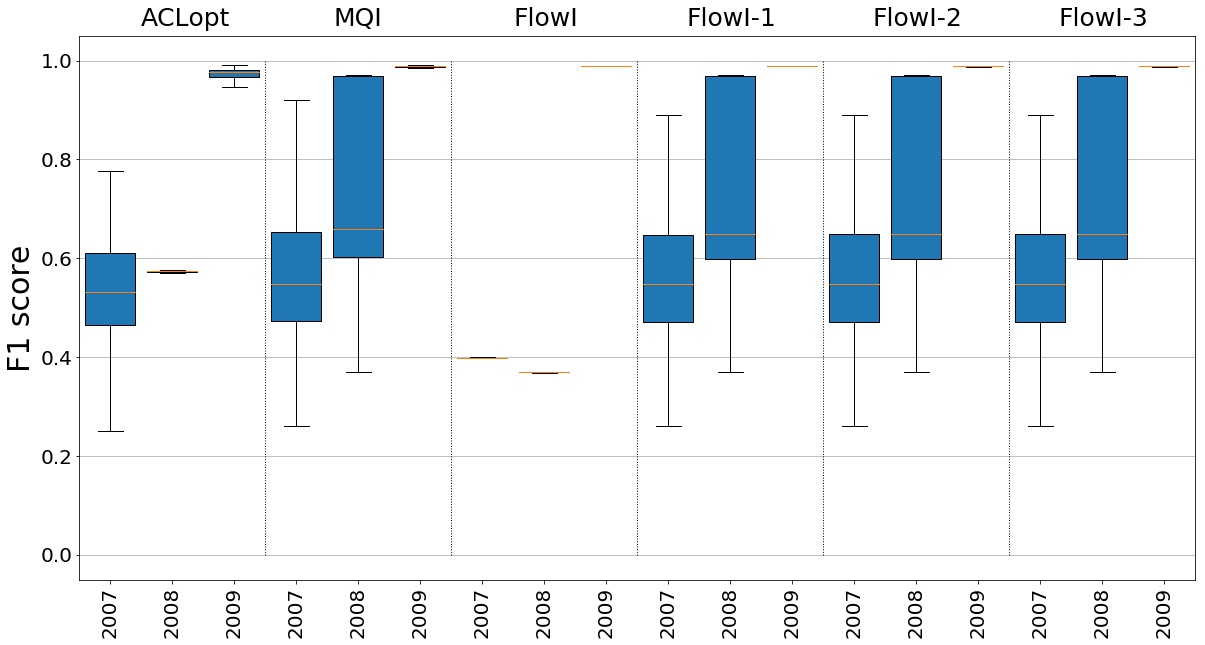

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_pre_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_f1_Optimal.png')

plt.show()

## Generate scatter plot for precision

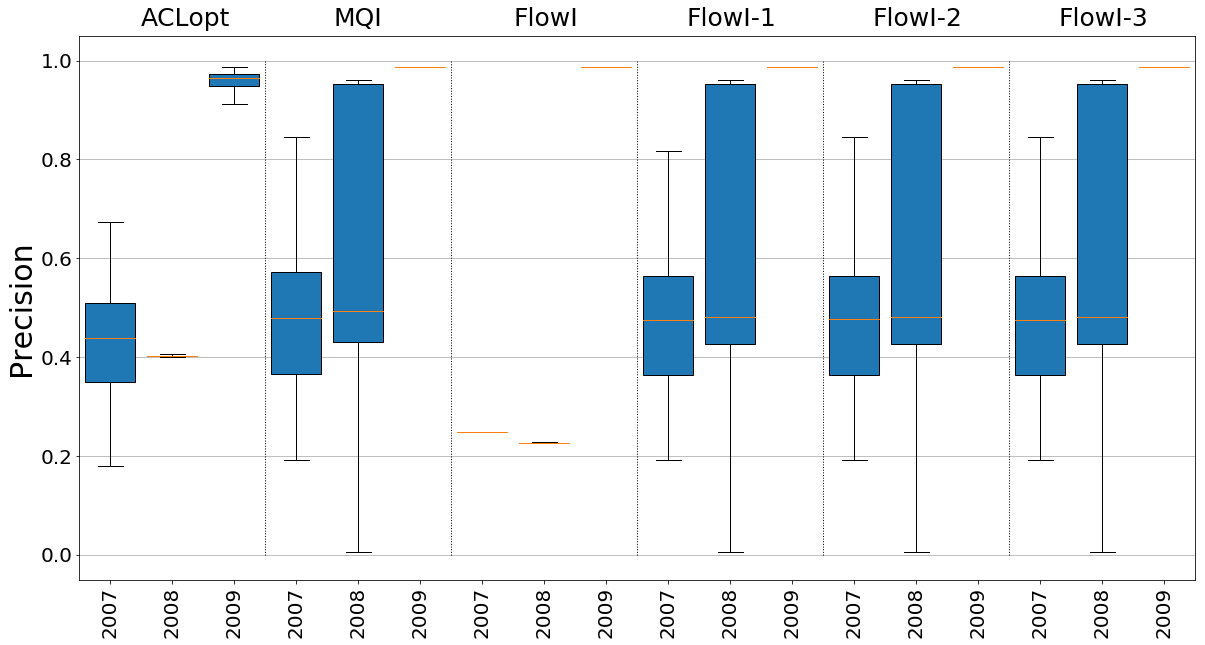

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_precision_Optimal.png')

plt.show()

## Generate scatter plot for recall

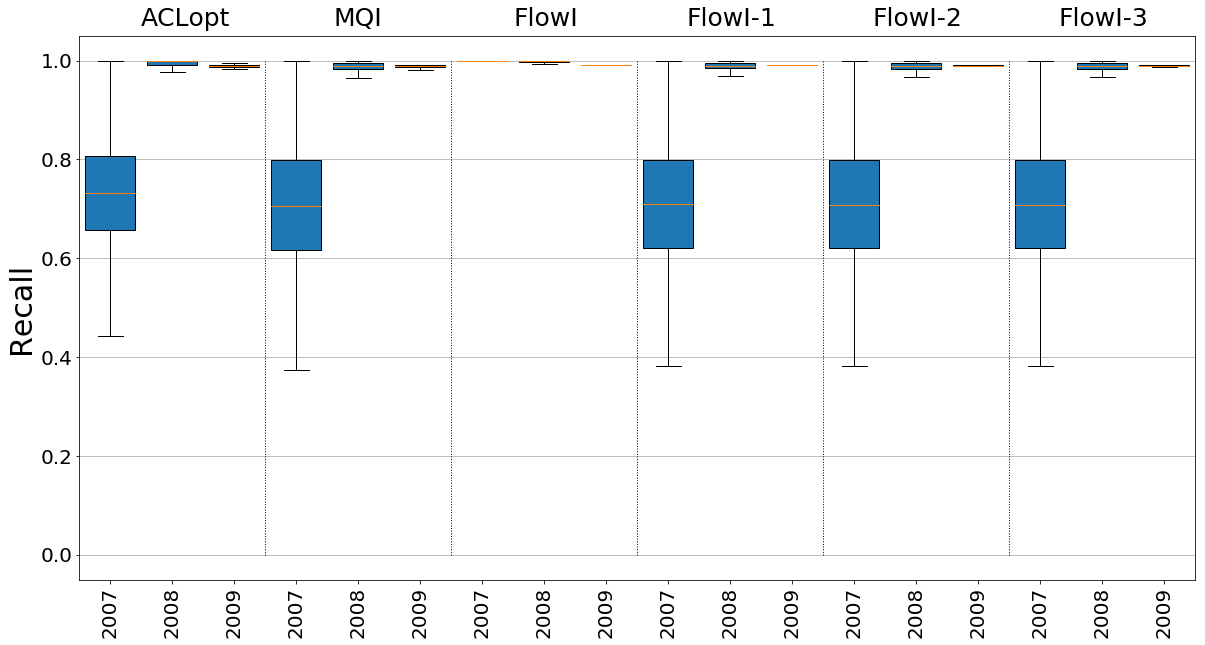

In [18]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_pre_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_recall_Optimal.png')

plt.show()

## Generate precision/recall and F1 scores

In [19]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
        temp_rec.append(recall_best_pre_acl[i,j])
        temp_f1.append(f1score_best_pre_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 2007 Precision 0.43928093804224466 Recall 0.7320966350301985 F1 0.5325331386013371
Feature: 2008 Precision 0.40252780963661017 Recall 0.9984702622178796 F1 0.5738614289324276
Feature: 2009 Precision 0.9655701143016449 Recall 0.9898215951822217 F1 0.9768624601799586
Results for MQI
Feature: 2007 Precision 0.4785791421848175 Recall 0.7051154560477326 F1 0.5488606736601598
Feature: 2008 Precision 0.4933661101437239 Recall 0.9887071713466498 F1 0.6601190759567528
Feature: 2009 Precision 0.9876577998196574 Recall 0.9896519551019254 F1 0.9886164623467599
Results for FlowI
Feature: 2007 Precision 0.24915286351676874 Recall 1.0 F1 0.3989015492364393
Feature: 2008 Precision 0.22678152296448856 Recall 0.9987345624629579 F1 0.3695877037284653
Feature: 2009 Precision 0.987243030132357 Recall 0.9913483559048885 F1 0.9892646042292663
Results for FlowI-1
Feature: 2007 Precision 0.475343482128918 Recall 0.7098974861438119 F1 0.5481547235752555
Feature: 2008 Precision 0.4808